**IOB-NST Algorithm based on the origial paper “A Neural Algorithm of Artistic Style” by Gatys et al.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==============================================
# IMPORT REQUIRED LIBRARIES
# ==============================================
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from PIL import Image
import matplotlib.pyplot as plt
import csv
from itertools import product
from pathlib import Path
from scipy.optimize import fmin_l_bfgs_b
from pathlib import Path
import time

# ==============================
# GLOBAL SETTINGS AND CONSTANTS
# ==============================

img_height = 512
result_prefix = "results"

# Define dataset directories

# Set content and style image folders in Google Drive
content_dir = '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/IOB-NST/Content'
style_dir = '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/IOB-NST/Style'

# Output folder (where stylized images will be saved)
output_dir = '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/IOB-NST/Stylized-Outputs'
csv_log_path = os.path.join(output_dir, "nst_results_log.csv")
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# ===================================
# IMAGE PROCESSING UTILITY FUNCTIONS
# ===================================

def preprocess_image(image_path, target_size):
#Loads and preprocesses an image for VGG19.
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)

def deprocess_image(x):
#Reverses VGG19 preprocessing to return a displayable image.
    x = x.reshape((img_height, img_width, 3))
    x[:, :, 0] += 103.939  # Add mean RGB values (reverse normalization)
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]      # Convert BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return Image.fromarray(x)

In [ ]:
# ==============================
# LOSS FUNCTION DEFINITIONS
# ==============================

def gram_matrix(x):
    # Ensure input is 4D: [1, H, W, C]
    result = tf.linalg.einsum('bijc,bijd->bcd', x, x)
    input_shape = tf.shape(x)
    H = tf.cast(input_shape[1], tf.float32)
    W = tf.cast(input_shape[2], tf.float32)
    C = tf.cast(input_shape[3], tf.float32)
    norm = H * W * C  # normalize by number of features * channels
    return tf.squeeze(result / norm, axis=0)

def total_variation_loss(x):
    a = tf.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = tf.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def plot_losses():
    plt.figure(figsize=(10, 6))
    plt.plot(content_losses, label='Content Loss')
    plt.plot(style_losses, label='Style Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss / Score')
    plt.title('Style Transfer Metrics Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# ==============================================
# EVALUATOR CLASS (FOR L-BFGS)
# ==============================================
class Evaluator:
    def __init__(self, loss_fn, shape):
        self.loss_fn = loss_fn
        self.shape = shape
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        loss, grads = self.loss_fn(x.reshape(self.shape))
        self.loss_value = loss
        self.grad_values = grads.flatten().astype('float64')
        return self.loss_value

    def grads(self, x):
        return self.grad_values

In [ ]:
# ===================================
# NEURAL STYLE TRANSFER FUNCTION
# ===================================
def run_style_transfer(content_path, style_path, output_path,
                       content_weight, style_weight, tv_weight,
                       optimizer_type, init_type,
                       iterations=300, learning_rate=10.0):

    start_time = time.time()

    global img_width
    width, height = load_img(content_path).size
    img_width = int(width * img_height / height)

    global content_losses, style_losses #,lpips_scores
    content_losses = []
    style_losses = []
    #lpips_scores = []

    # Preprocess content and style images
    content_image = preprocess_image(content_path, (img_height, img_width))
    style_image = preprocess_image(style_path, (img_height, img_width))

    # Initialize combination image
    if init_type == "content":
        combo_img = tf.Variable(content_image, dtype=tf.float32)
    else:
        noise_img = tf.random.uniform(content_image.shape, 0, 255)
        noise_img = vgg19.preprocess_input(noise_img)
        combo_img = tf.Variable(noise_img, dtype=tf.float32)

    # Load pre-trained VGG19 model
    vgg = vgg19.VGG19(weights='imagenet', include_top=False)
    vgg.trainable = False

    # Layers to extract features from
    content_layer = 'block5_conv2'
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    output_layers = [content_layer] + style_layers

    # Build model that outputs selected layer activations
    outputs = [vgg.get_layer(name).output for name in output_layers]
    feature_extractor = Model(inputs=vgg.input, outputs=outputs)

    # Extract features for content and style images
    content_features = feature_extractor(content_image)[0]
    style_features = feature_extractor(style_image)[1:]

    # Define loss + gradients function
    def loss_and_grads(x_tensor):
        with tf.GradientTape() as tape:
            outputs = feature_extractor(x_tensor)
            c_out = outputs[0]
            s_outs = outputs[1:]

            c_loss = content_weight * tf.reduce_mean(tf.square(c_out - content_features))

            s_loss = 0
            for sF, sO in zip(style_features, s_outs):
                s_loss += tf.reduce_mean(tf.square(gram_matrix(sF) - gram_matrix(sO)))

            s_loss *= style_weight / len(style_layers)
            tv_loss = tv_weight * total_variation_loss(x_tensor)
            total = c_loss + s_loss + tv_loss

        grads = tape.gradient(total, x_tensor)

        return total, grads, c_loss, s_loss

    # Optimizer
    if optimizer_type == 'adam':
            optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

            #Optimization loop
            for i in range(iterations):
                loss, grads, c_l, s_l = loss_and_grads(combo_img)
                optimizer.apply_gradients([(grads, combo_img)])

                #Track metrics
                content_losses.append(c_l.numpy())
                style_losses.append(s_l.numpy())

                if (i+1) % 10 == 0:
                    print(f"[{i+1}/{iterations}] Total: {loss.numpy():,.2f} | Content: {c_l.numpy():,.2f} | Style: {s_l.numpy():,.2f}")

    else:  # L-BFGS optimization
        lbfgs_step = [0]  # mutable counter
        def wrapped_loss(x):
            x_tensor = tf.convert_to_tensor(x.reshape((1, img_height, img_width, 3)), dtype=tf.float32)
            x_var = tf.Variable(x_tensor)  # Make sure it's a variable
            loss, grads, c_l, s_l = loss_and_grads(x_var)

            #Track metrics
            content_losses.append(c_l.numpy())
            style_losses.append(s_l.numpy())

            lbfgs_step[0] += 1
            if lbfgs_step[0] % 10 == 0:
                print(f"LBFGS Step [{lbfgs_step[0]}] Total: {loss.numpy():,.2f} | Content: {c_l.numpy():,.2f} | Style: {s_l.numpy():,.2f}")

            return loss.numpy().astype("float64"), grads.numpy().flatten().astype("float64")

        evaluator = Evaluator(wrapped_loss, (1, img_height, img_width, 3))
        x_opt, _, _ = fmin_l_bfgs_b(evaluator.loss,
                                    combo_img.numpy().flatten(),
                                    fprime=evaluator.grads,
                                    maxiter=iterations)

        combo_img = tf.convert_to_tensor(x_opt.reshape((1, img_height, img_width, 3)))

    # Save final image
    total_time = time.time() - start_time
    final_img = deprocess_image(combo_img.numpy())
    final_img.save(output_path)
    print(f"Runtime: {total_time:.2f} seconds")
    print(f"Saved: {output_path}")

    # Plot metrics
    plot_losses()

    # Return final loss values
    return content_losses[-1], style_losses[-1], total_time #, lpips_scores[-1]

In [ ]:
# ==============================================
# GRID SEARCH OVER HYPERPARAMETERS + LOGGING
# ==============================================

# Define grid values
content_weights = [1e2, 1e3, 1e4]
style_weights = [1e3, 1e4, 1e5]
tv_weights = [1e-6, 1e-5, 1e-4]
optimizers = ['adam', 'lbfgs']
init_methods = ['content']

# Prepare CSV log file
if not os.path.exists(csv_log_path):
    with open(csv_log_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "run_index", "run_id", "content_file", "style_file",
            "content_weight", "style_weight", "tv_weight",
            "optimizer", "init_type", "iterations", "learning_rate",
            "final_content_loss", "final_style_loss",
            "runtime_sec",
            "output_path"
        ])


Running [0] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_1000.0_1e-06_adam_content
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[10/300] Total: 11,061,916.00 | Content: 394,317.03 | Style: 10,638,988.00
[20/300] Total: 4,643,683.00 | Content: 398,159.84 | Style: 4,218,558.00
[30/300] Total: 2,506,513.00 | Content: 388,514.22 | Style: 2,094,333.25
[40/300] Total: 1,805,435.50 | Content: 366,951.72 | Style: 1,415,694.25
[50/300] Total: 1,405,520.50 | Content: 337,637.97 | Style: 1,045,000.12
[60/300] Total: 1,161,274.50 | Content: 312,697.34 | Style: 825,642.88
[70/300] Total: 1,010,098.50 | Content: 291,047.81 | Style: 696,292.19
[80/300] Total: 870,132.12 | Content: 271,874.50 | Style: 575,660.75
[90/300] Total: 792,156.44 | Content: 256,223.00 | Style: 513,400.88
[100/300] Total: 731,583.75 | Content: 244,946.78 | Style: 464,170.69
[1

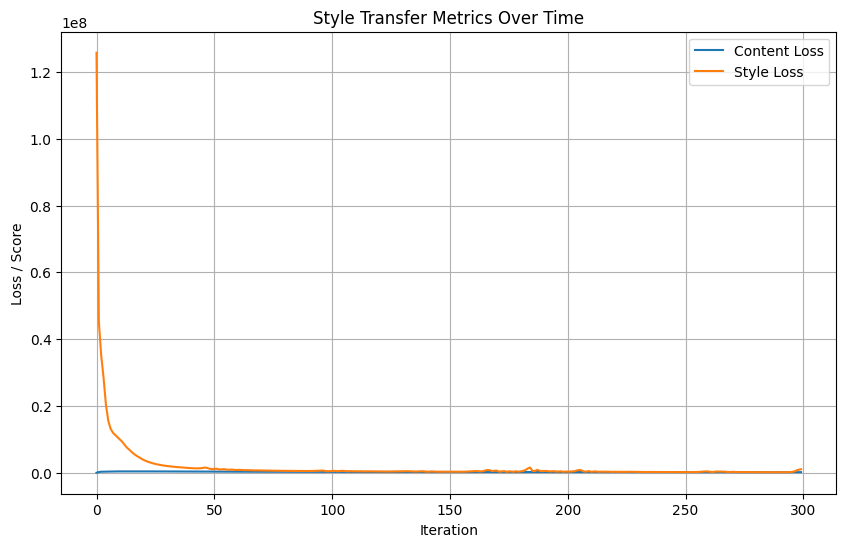


Running [1] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_1000.0_1e-06_lbfgs_content
LBFGS Step [10] Total: 19,229,898.00 | Content: 253,903.12 | Style: 18,960,830.00
LBFGS Step [20] Total: 4,440,483.00 | Content: 358,211.88 | Style: 4,066,001.50
LBFGS Step [30] Total: 2,576,104.25 | Content: 339,921.72 | Style: 2,221,304.75
LBFGS Step [40] Total: 1,937,309.50 | Content: 315,636.75 | Style: 1,607,236.38
LBFGS Step [50] Total: 1,510,944.00 | Content: 293,375.62 | Style: 1,203,429.62
LBFGS Step [60] Total: 1,184,057.62 | Content: 270,314.91 | Style: 899,906.56
LBFGS Step [70] Total: 942,723.31 | Content: 254,834.11 | Style: 674,364.19
LBFGS Step [80] Total: 782,247.00 | Content: 237,982.78 | Style: 530,934.88
LBFGS Step [90] Total: 644,298.50 | Content: 219,945.02 | Style: 411,301.50
LBFGS Step [100] Total: 554,514.12 | Content: 207,595.62 | St

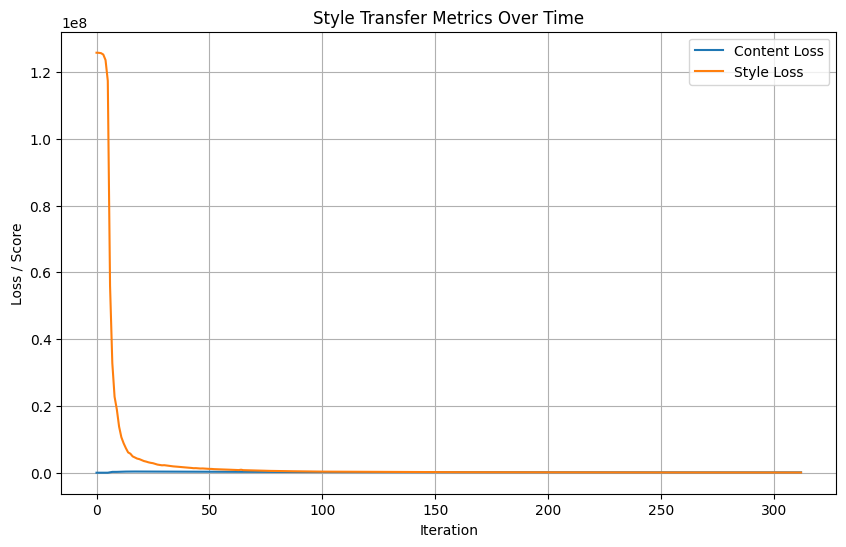


Running [2] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_1000.0_1e-05_adam_content
[10/300] Total: 11,266,962.00 | Content: 394,272.31 | Style: 10,589,239.00
[20/300] Total: 4,842,804.50 | Content: 398,154.56 | Style: 4,182,895.25
[30/300] Total: 2,698,585.50 | Content: 388,022.94 | Style: 2,087,968.75
[40/300] Total: 1,986,486.88 | Content: 366,265.81 | Style: 1,413,734.88
[50/300] Total: 1,589,684.00 | Content: 336,843.56 | Style: 1,053,460.00
[60/300] Total: 1,382,368.12 | Content: 314,273.66 | Style: 875,551.06
[70/300] Total: 1,198,625.62 | Content: 291,825.38 | Style: 723,903.69
[80/300] Total: 1,024,546.69 | Content: 273,311.44 | Style: 576,660.56
[90/300] Total: 923,625.25 | Content: 257,408.08 | Style: 498,975.34
[100/300] Total: 1,269,637.25 | Content: 246,676.64 | Style: 861,655.19
[110/300] Total: 879,132.62 | Content: 242,642.89

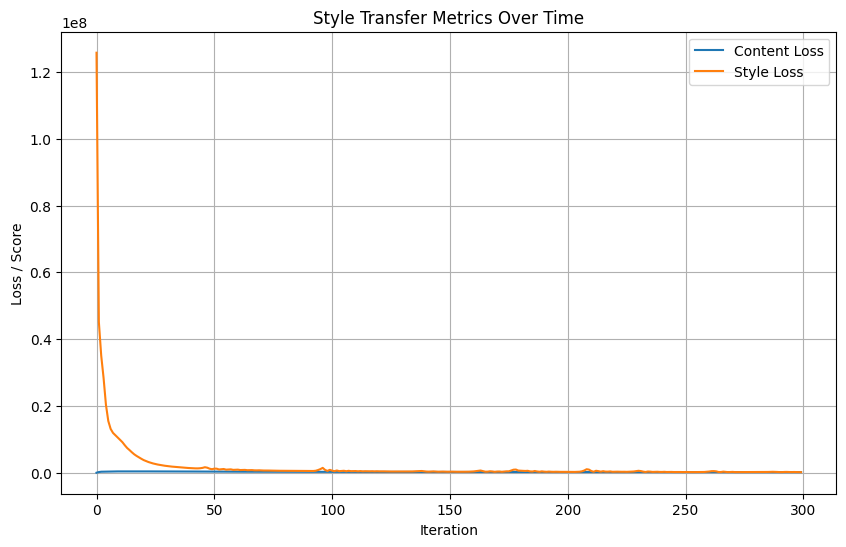


Running [3] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_1000.0_1e-05_lbfgs_content
LBFGS Step [10] Total: 19,368,162.00 | Content: 253,911.53 | Style: 18,962,834.00
LBFGS Step [20] Total: 4,560,145.50 | Content: 357,989.28 | Style: 4,041,973.50
LBFGS Step [30] Total: 2,714,874.50 | Content: 340,696.88 | Style: 2,230,936.00
LBFGS Step [40] Total: 2,000,100.62 | Content: 314,276.34 | Style: 1,550,837.25
LBFGS Step [50] Total: 1,643,902.00 | Content: 289,795.44 | Style: 1,225,983.25
LBFGS Step [60] Total: 1,245,320.88 | Content: 273,013.62 | Style: 850,314.62
LBFGS Step [70] Total: 987,186.38 | Content: 257,616.31 | Style: 615,785.94
LBFGS Step [80] Total: 820,499.75 | Content: 236,950.48 | Style: 474,519.59
LBFGS Step [90] Total: 707,522.12 | Content: 223,641.11 | Style: 379,605.69
LBFGS Step [100] Total: 628,390.75 | Content: 210,224.41 | St

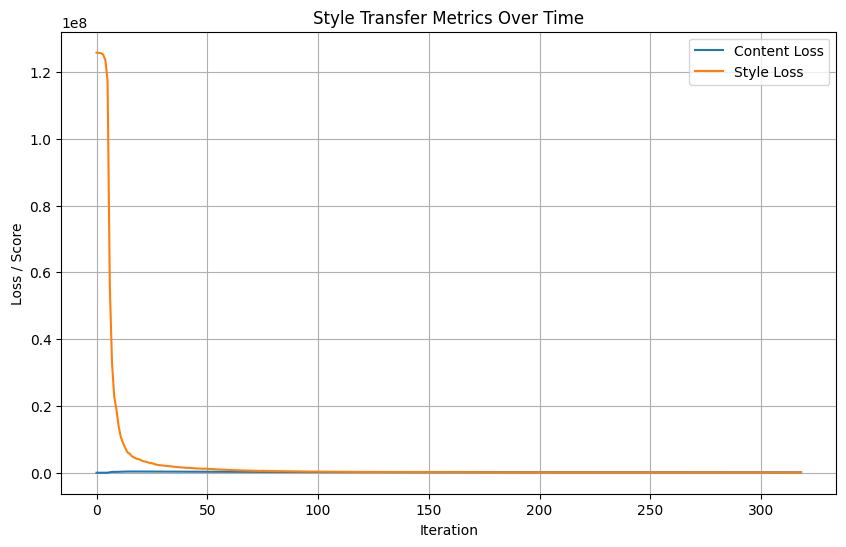


Running [4] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_1000.0_0.0001_adam_content
[10/300] Total: 13,148,526.00 | Content: 394,774.19 | Style: 10,157,449.00
[20/300] Total: 6,314,370.00 | Content: 397,842.56 | Style: 3,879,545.75
[30/300] Total: 3,885,590.00 | Content: 388,595.69 | Style: 2,049,873.88
[40/300] Total: 3,052,706.00 | Content: 364,648.06 | Style: 1,523,487.88
[50/300] Total: 2,518,222.25 | Content: 336,858.31 | Style: 1,153,937.75
[60/300] Total: 2,104,900.00 | Content: 313,476.34 | Style: 860,005.75
[70/300] Total: 1,873,996.75 | Content: 292,177.03 | Style: 735,392.75
[80/300] Total: 1,685,278.62 | Content: 273,488.38 | Style: 628,617.31
[90/300] Total: 1,673,773.50 | Content: 260,053.00 | Style: 675,495.69
[100/300] Total: 1,861,736.25 | Content: 261,688.97 | Style: 867,219.75
[110/300] Total: 1,474,590.25 | Content: 255,3

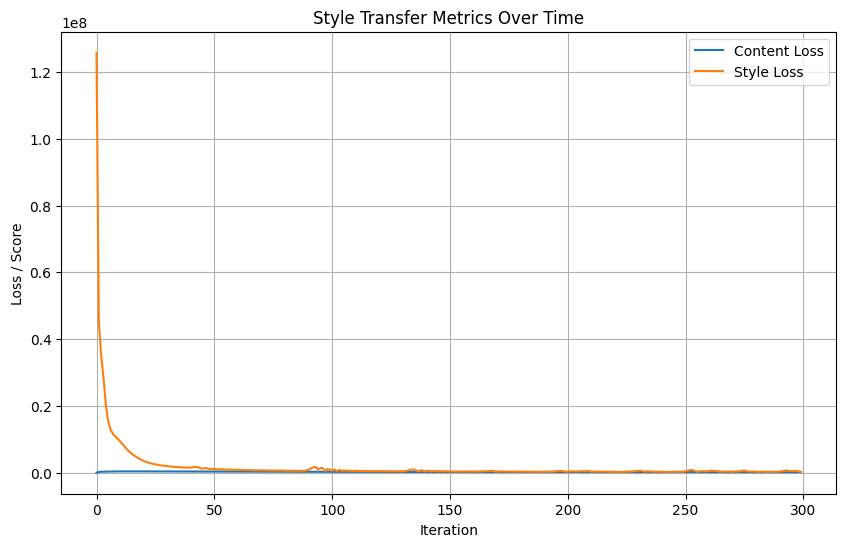


Running [5] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_1000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 20,717,614.00 | Content: 254,065.16 | Style: 18,971,142.00
LBFGS Step [20] Total: 5,762,764.00 | Content: 360,200.81 | Style: 4,010,798.75
LBFGS Step [30] Total: 3,659,334.25 | Content: 345,480.06 | Style: 2,271,119.75
LBFGS Step [40] Total: 3,075,765.00 | Content: 324,078.03 | Style: 1,841,960.00
LBFGS Step [50] Total: 2,423,027.25 | Content: 295,791.47 | Style: 1,290,608.00
LBFGS Step [60] Total: 1,980,350.25 | Content: 277,093.72 | Style: 927,268.00
LBFGS Step [70] Total: 1,712,814.00 | Content: 267,800.44 | Style: 709,619.75
LBFGS Step [80] Total: 1,531,362.75 | Content: 249,215.89 | Style: 594,041.25
LBFGS Step [90] Total: 1,379,891.50 | Content: 232,750.34 | Style: 496,890.09
LBFGS Step [100] Total: 1,259,003.38 | Content: 221,61

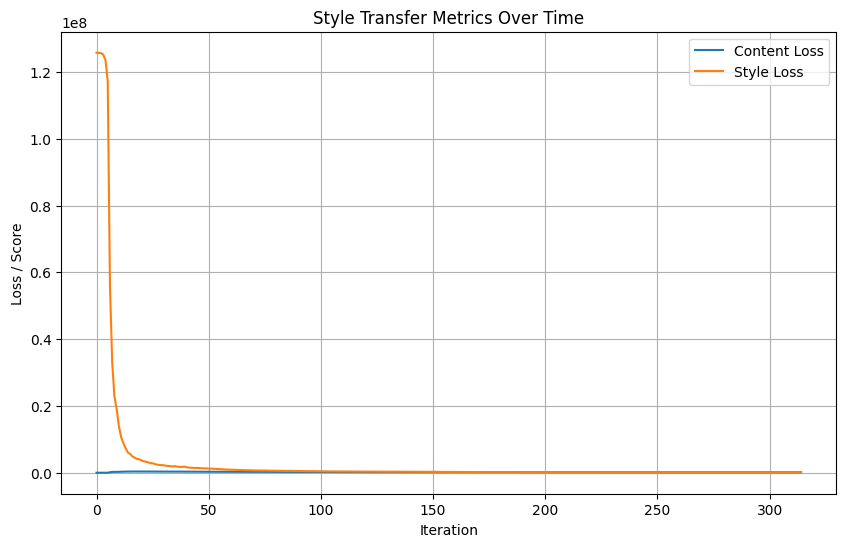


Running [6] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_10000.0_1e-06_adam_content
[10/300] Total: 106,983,288.00 | Content: 404,764.16 | Style: 106,549,880.00
[20/300] Total: 42,679,500.00 | Content: 425,322.56 | Style: 42,227,112.00
[30/300] Total: 21,348,236.00 | Content: 440,964.25 | Style: 20,883,444.00
[40/300] Total: 14,561,039.00 | Content: 450,757.88 | Style: 14,087,251.00
[50/300] Total: 10,928,471.00 | Content: 449,786.12 | Style: 10,455,459.00
[60/300] Total: 8,547,563.00 | Content: 448,692.97 | Style: 8,075,480.00
[70/300] Total: 7,061,871.50 | Content: 447,640.44 | Style: 6,590,890.50
[80/300] Total: 5,739,395.50 | Content: 443,285.09 | Style: 5,272,797.00
[90/300] Total: 5,997,767.50 | Content: 441,530.81 | Style: 5,532,802.00
[100/300] Total: 4,821,039.50 | Content: 437,159.47 | Style: 4,360,360.00
[110/300] Total: 5,416,783

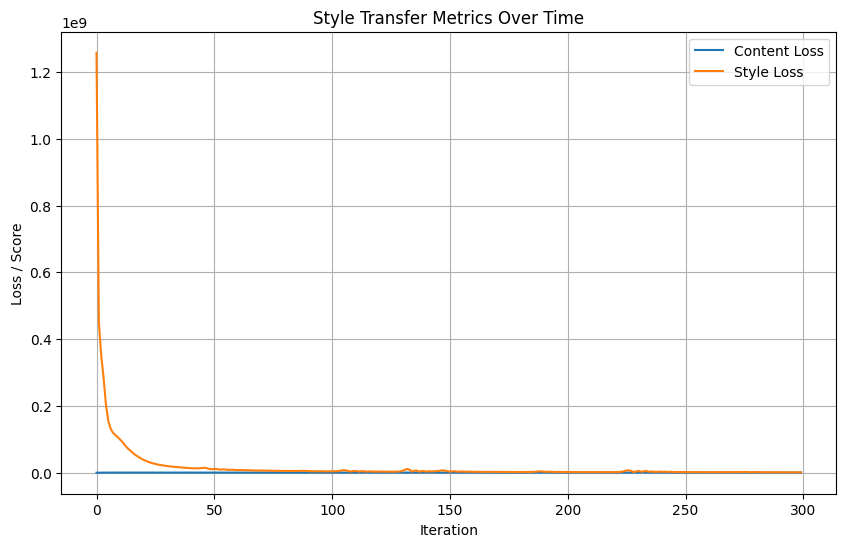


Running [7] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_10000.0_1e-06_lbfgs_content
LBFGS Step [10] Total: 189,759,936.00 | Content: 257,653.81 | Style: 189,487,120.00
LBFGS Step [20] Total: 42,146,596.00 | Content: 388,053.50 | Style: 41,742,248.00
LBFGS Step [30] Total: 23,745,698.00 | Content: 404,360.06 | Style: 23,326,420.00
LBFGS Step [40] Total: 16,608,308.00 | Content: 417,514.31 | Style: 16,176,177.00
LBFGS Step [50] Total: 12,133,142.00 | Content: 420,162.44 | Style: 11,698,715.00
LBFGS Step [60] Total: 8,906,171.00 | Content: 422,614.84 | Style: 8,469,763.00
LBFGS Step [70] Total: 6,513,046.50 | Content: 425,244.88 | Style: 6,074,255.50
LBFGS Step [80] Total: 4,869,380.50 | Content: 426,402.00 | Style: 4,429,520.50
LBFGS Step [90] Total: 3,921,658.00 | Content: 423,279.41 | Style: 3,485,138.50
LBFGS Step [100] Total: 3,250,695.50

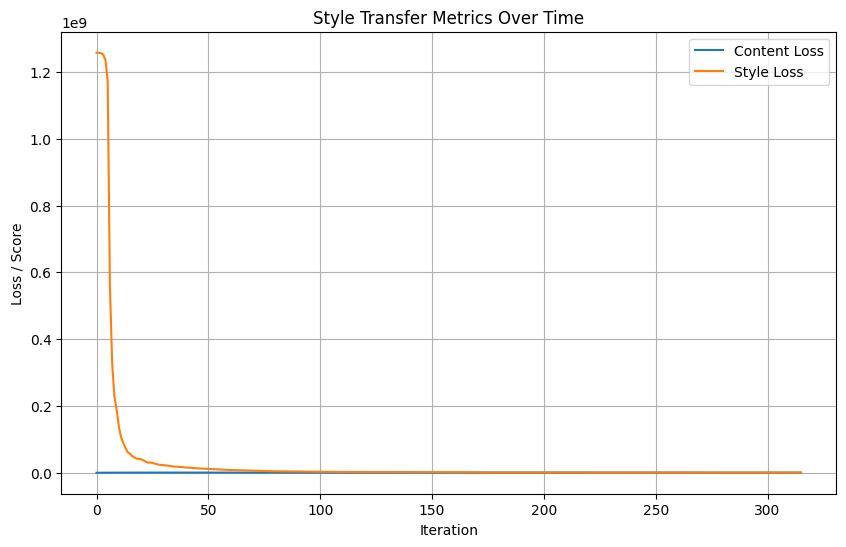


Running [8] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_10000.0_1e-05_adam_content
[10/300] Total: 107,210,424.00 | Content: 404,724.31 | Style: 106,519,600.00
[20/300] Total: 42,894,444.00 | Content: 425,374.66 | Style: 42,199,276.00
[30/300] Total: 21,547,142.00 | Content: 441,090.47 | Style: 20,869,350.00
[40/300] Total: 14,769,589.00 | Content: 450,988.22 | Style: 14,090,716.00
[50/300] Total: 11,008,289.00 | Content: 450,320.84 | Style: 10,329,191.00
[60/300] Total: 8,963,116.00 | Content: 447,836.09 | Style: 8,286,202.00
[70/300] Total: 7,087,394.50 | Content: 446,963.69 | Style: 6,413,070.50
[80/300] Total: 6,090,724.50 | Content: 442,456.06 | Style: 5,422,634.50
[90/300] Total: 5,947,085.50 | Content: 441,330.53 | Style: 5,280,436.00
[100/300] Total: 7,419,544.00 | Content: 441,250.09 | Style: 6,751,844.00
[110/300] Total: 4,753,618

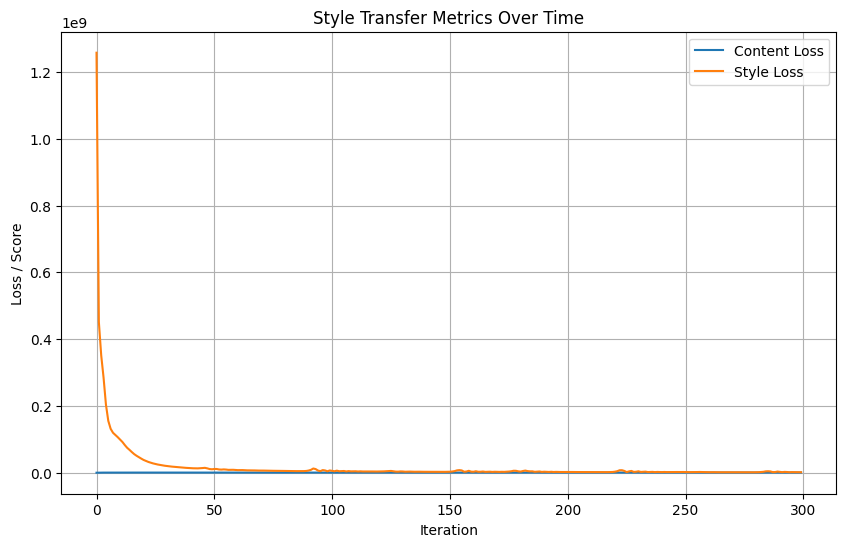


Running [9] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_10000.0_1e-05_lbfgs_content
LBFGS Step [10] Total: 189,900,528.00 | Content: 257,657.45 | Style: 189,491,216.00
LBFGS Step [20] Total: 42,380,880.00 | Content: 387,824.56 | Style: 41,830,444.00
LBFGS Step [30] Total: 23,059,266.00 | Content: 402,167.22 | Style: 22,507,606.00
LBFGS Step [40] Total: 15,643,360.00 | Content: 420,244.00 | Style: 15,078,916.00
LBFGS Step [50] Total: 11,118,400.00 | Content: 422,891.06 | Style: 10,556,982.00
LBFGS Step [60] Total: 8,211,881.00 | Content: 423,525.78 | Style: 7,652,998.50
LBFGS Step [70] Total: 6,152,681.50 | Content: 429,492.19 | Style: 5,590,435.00
LBFGS Step [80] Total: 4,757,676.00 | Content: 429,445.91 | Style: 4,197,931.50
LBFGS Step [90] Total: 3,928,450.50 | Content: 425,165.81 | Style: 3,375,024.00
LBFGS Step [100] Total: 3,233,638.00

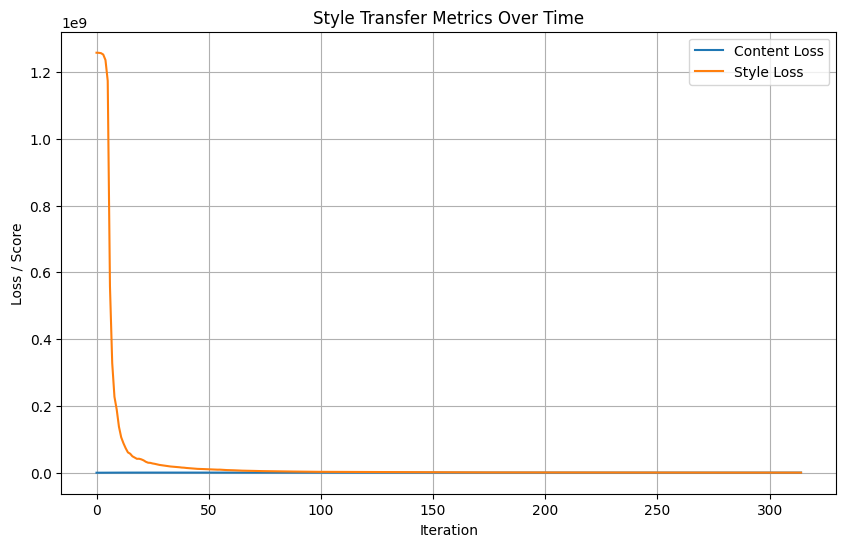


Running [10] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_10000.0_0.0001_adam_content
[10/300] Total: 109,243,968.00 | Content: 405,155.53 | Style: 106,004,008.00
[20/300] Total: 44,863,348.00 | Content: 425,765.72 | Style: 41,819,176.00
[30/300] Total: 23,461,036.00 | Content: 440,917.62 | Style: 20,793,046.00
[40/300] Total: 16,572,083.00 | Content: 451,216.56 | Style: 14,055,456.00
[50/300] Total: 13,068,732.00 | Content: 450,143.38 | Style: 10,625,743.00
[60/300] Total: 10,330,486.00 | Content: 449,580.47 | Style: 7,960,215.50
[70/300] Total: 8,846,465.00 | Content: 447,563.12 | Style: 6,571,618.00
[80/300] Total: 7,629,833.50 | Content: 443,667.19 | Style: 5,445,837.00
[90/300] Total: 7,772,535.50 | Content: 437,125.16 | Style: 5,672,596.00
[100/300] Total: 6,441,015.00 | Content: 436,473.78 | Style: 4,398,558.00
[110/300] Total: 5,780,

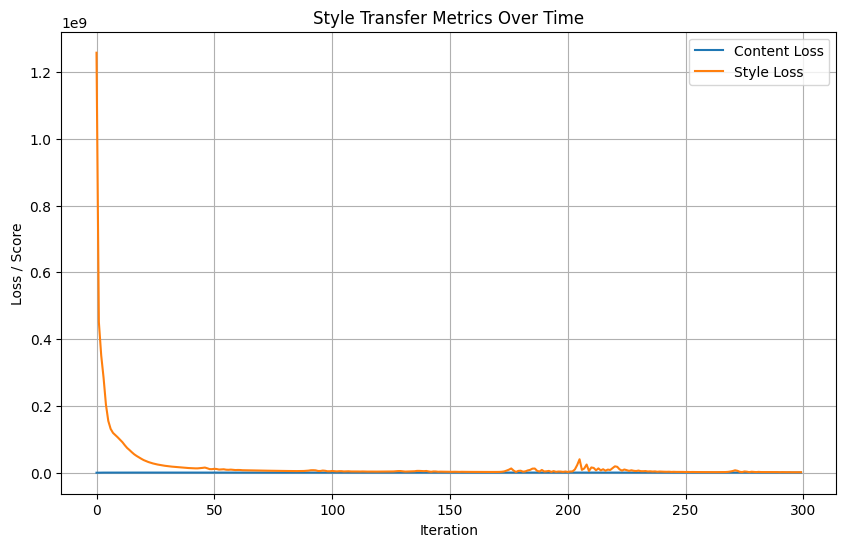


Running [11] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_10000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 191,288,384.00 | Content: 257,663.25 | Style: 189,516,416.00
LBFGS Step [20] Total: 43,694,688.00 | Content: 387,396.81 | Style: 41,705,660.00
LBFGS Step [30] Total: 25,030,326.00 | Content: 406,133.69 | Style: 23,196,670.00
LBFGS Step [40] Total: 19,219,978.00 | Content: 409,093.88 | Style: 17,429,998.00
LBFGS Step [50] Total: 13,825,877.00 | Content: 418,962.22 | Style: 12,118,823.00
LBFGS Step [60] Total: 10,873,570.00 | Content: 421,306.16 | Style: 9,218,462.00
LBFGS Step [70] Total: 8,352,344.00 | Content: 427,192.44 | Style: 6,756,534.00
LBFGS Step [80] Total: 6,513,483.00 | Content: 429,562.84 | Style: 4,978,116.50
LBFGS Step [90] Total: 5,454,012.50 | Content: 426,437.75 | Style: 3,967,077.75
LBFGS Step [100] Total: 4,509,823

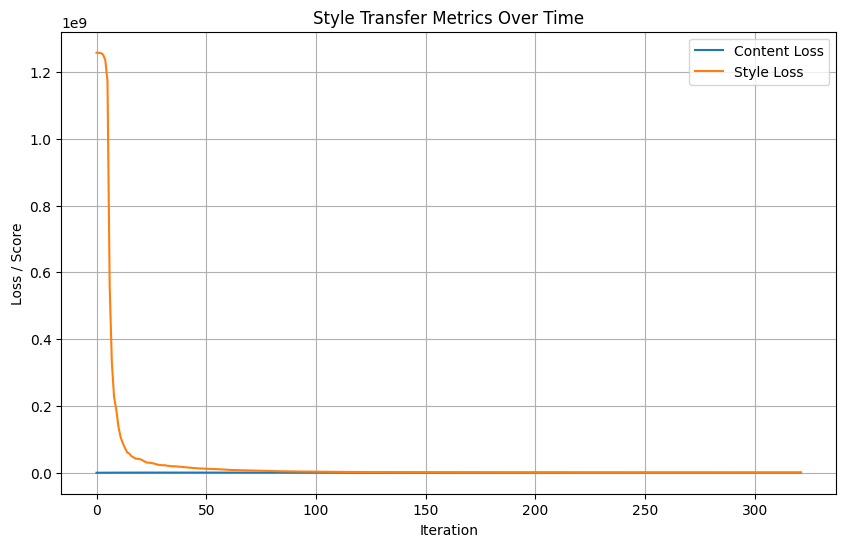


Running [12] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_100000.0_1e-06_adam_content
[10/300] Total: 1,066,312,000.00 | Content: 405,719.06 | Style: 1,065,877,632.00
[20/300] Total: 422,908,896.00 | Content: 428,238.97 | Style: 422,453,600.00
[30/300] Total: 209,250,768.00 | Content: 446,302.25 | Style: 208,780,624.00
[40/300] Total: 141,507,536.00 | Content: 460,497.25 | Style: 141,023,984.00
[50/300] Total: 102,897,832.00 | Content: 465,049.56 | Style: 102,409,512.00
[60/300] Total: 85,088,888.00 | Content: 466,882.97 | Style: 84,598,584.00
[70/300] Total: 64,049,956.00 | Content: 471,173.62 | Style: 63,555,392.00
[80/300] Total: 55,348,580.00 | Content: 471,970.16 | Style: 54,853,224.00
[90/300] Total: 45,081,372.00 | Content: 474,502.94 | Style: 44,583,368.00
[100/300] Total: 101,509,864.00 | Content: 472,767.38 | Style: 101,013,416.00


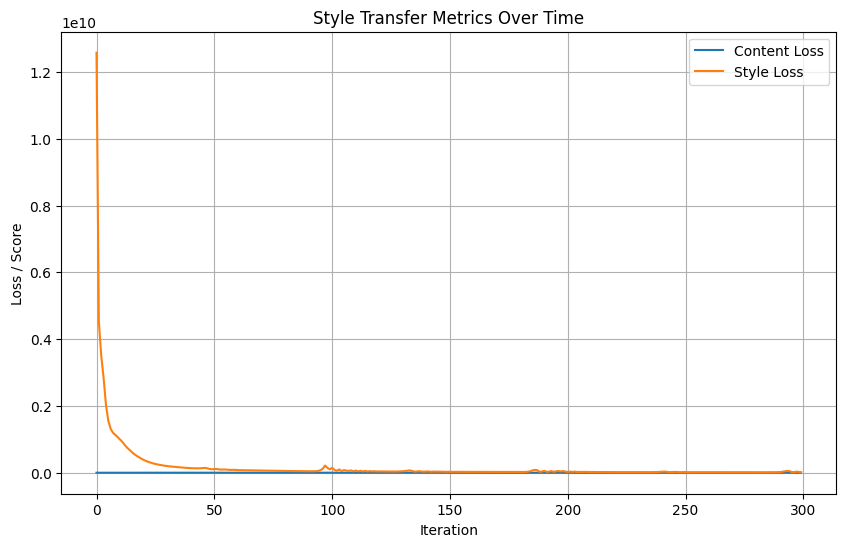


Running [13] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_100000.0_1e-06_lbfgs_content
LBFGS Step [10] Total: 1,895,583,488.00 | Content: 258,039.33 | Style: 1,895,310,336.00
LBFGS Step [20] Total: 418,077,184.00 | Content: 390,482.91 | Style: 417,670,400.00
LBFGS Step [30] Total: 223,648,032.00 | Content: 409,708.75 | Style: 223,223,328.00
LBFGS Step [40] Total: 168,765,408.00 | Content: 425,817.62 | Style: 168,325,056.00
LBFGS Step [50] Total: 117,518,080.00 | Content: 434,305.22 | Style: 117,069,568.00
LBFGS Step [60] Total: 82,161,936.00 | Content: 446,494.19 | Style: 81,701,528.00
LBFGS Step [70] Total: 61,458,948.00 | Content: 456,652.19 | Style: 60,988,592.00
LBFGS Step [80] Total: 48,061,968.00 | Content: 460,733.69 | Style: 47,587,696.00
LBFGS Step [90] Total: 37,437,736.00 | Content: 465,713.47 | Style: 36,958,740.00
LBFGS Step [10

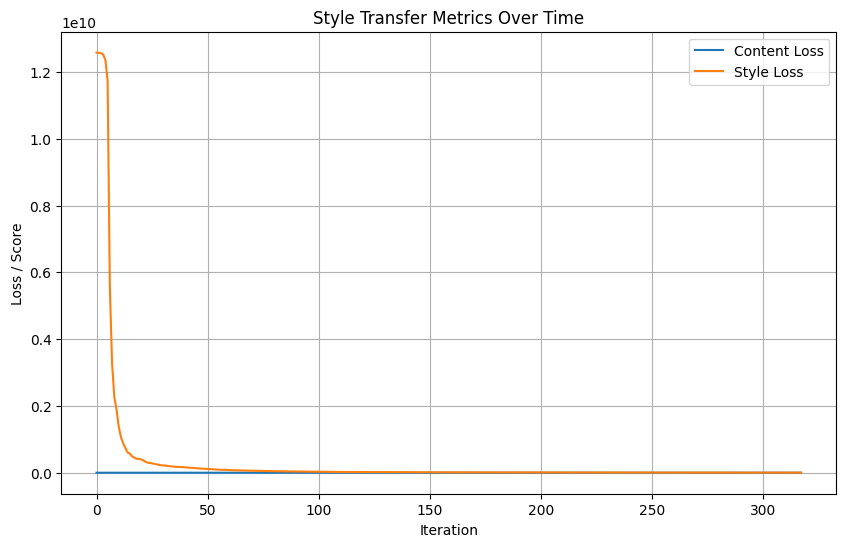


Running [14] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_100000.0_1e-05_adam_content
[10/300] Total: 1,066,564,736.00 | Content: 405,757.12 | Style: 1,065,872,576.00
[20/300] Total: 423,039,680.00 | Content: 428,215.56 | Style: 422,340,832.00
[30/300] Total: 209,432,416.00 | Content: 446,314.00 | Style: 208,747,856.00
[40/300] Total: 141,706,944.00 | Content: 460,278.06 | Style: 141,016,368.00
[50/300] Total: 103,480,560.00 | Content: 464,174.94 | Style: 102,784,080.00
[60/300] Total: 84,752,848.00 | Content: 466,395.41 | Style: 84,052,704.00
[70/300] Total: 64,285,904.00 | Content: 470,929.25 | Style: 63,581,612.00
[80/300] Total: 55,668,048.00 | Content: 471,812.25 | Style: 54,963,156.00
[90/300] Total: 45,696,288.00 | Content: 474,215.88 | Style: 44,988,036.00
[100/300] Total: 96,376,200.00 | Content: 477,813.03 | Style: 95,662,152.00
[1

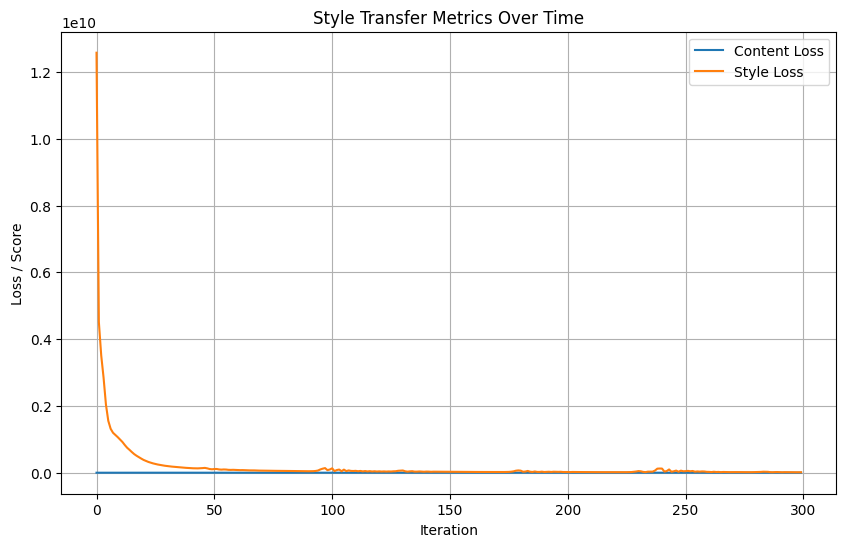


Running [15] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_100000.0_1e-05_lbfgs_content
LBFGS Step [10] Total: 1,895,708,416.00 | Content: 258,036.53 | Style: 1,895,298,688.00
LBFGS Step [20] Total: 418,060,928.00 | Content: 390,732.00 | Style: 417,507,264.00
LBFGS Step [30] Total: 233,421,424.00 | Content: 408,763.69 | Style: 232,864,320.00
LBFGS Step [40] Total: 169,499,424.00 | Content: 418,613.00 | Style: 168,935,104.00
LBFGS Step [50] Total: 116,259,128.00 | Content: 434,866.47 | Style: 115,681,664.00
LBFGS Step [60] Total: 83,033,088.00 | Content: 448,497.81 | Style: 82,445,072.00
LBFGS Step [70] Total: 61,805,020.00 | Content: 456,840.25 | Style: 61,212,056.00
LBFGS Step [80] Total: 46,271,780.00 | Content: 461,883.25 | Style: 45,675,848.00
LBFGS Step [90] Total: 36,312,212.00 | Content: 467,988.69 | Style: 35,711,432.00
LBFGS Step [10

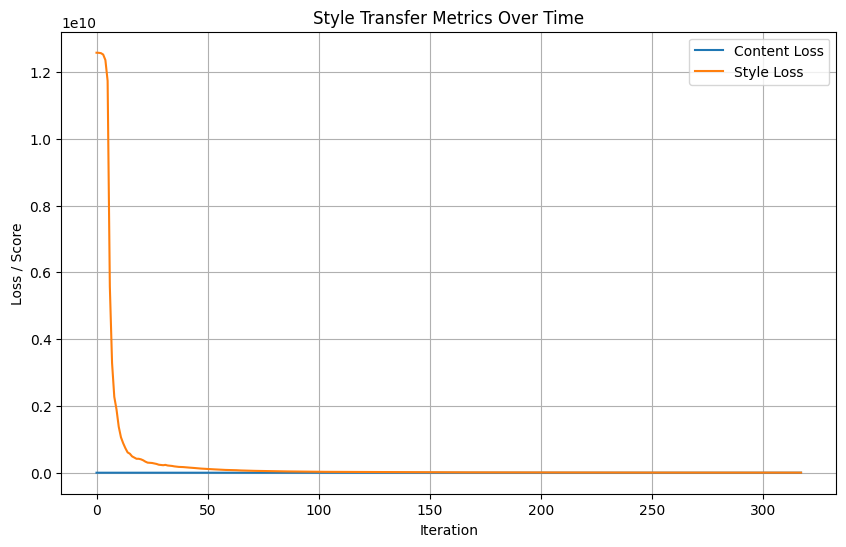


Running [16] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_100000.0_0.0001_adam_content
[10/300] Total: 1,068,651,200.00 | Content: 405,799.19 | Style: 1,065,384,320.00
[20/300] Total: 425,092,256.00 | Content: 428,254.00 | Style: 421,966,048.00
[30/300] Total: 211,491,536.00 | Content: 446,325.69 | Style: 208,677,968.00
[40/300] Total: 143,509,280.00 | Content: 460,332.44 | Style: 140,770,320.00
[50/300] Total: 105,606,544.00 | Content: 464,619.28 | Style: 102,854,200.00
[60/300] Total: 84,121,784.00 | Content: 467,484.66 | Style: 81,362,984.00
[70/300] Total: 68,667,216.00 | Content: 472,291.41 | Style: 65,920,760.00
[80/300] Total: 55,648,664.00 | Content: 473,741.56 | Style: 52,917,260.00
[90/300] Total: 52,761,068.00 | Content: 476,327.06 | Style: 50,031,740.00
[100/300] Total: 58,233,536.00 | Content: 473,125.69 | Style: 55,518,316.00
[

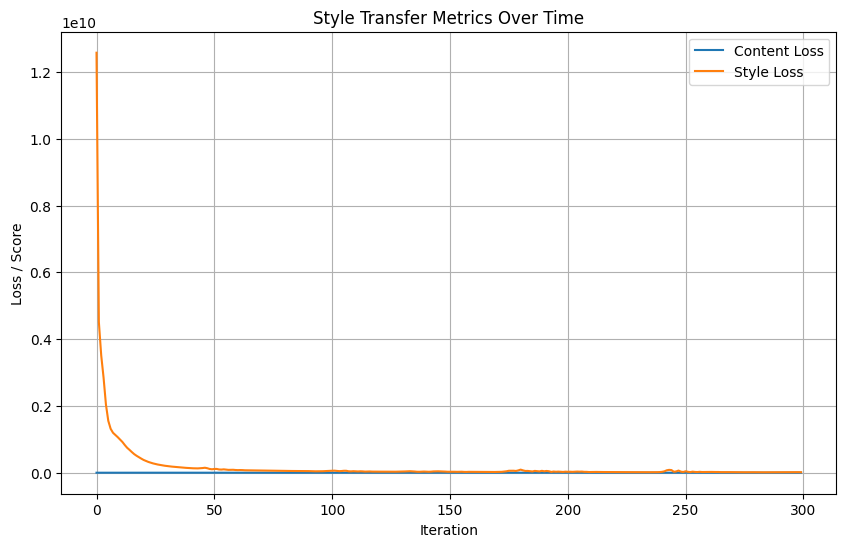


Running [17] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_100.0_100000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 1,897,070,080.00 | Content: 258,035.25 | Style: 1,895,295,616.00
LBFGS Step [20] Total: 419,583,040.00 | Content: 390,143.78 | Style: 417,565,312.00
LBFGS Step [30] Total: 296,476,000.00 | Content: 413,202.94 | Style: 294,571,968.00
LBFGS Step [40] Total: 170,836,464.00 | Content: 420,611.22 | Style: 168,964,880.00
LBFGS Step [50] Total: 114,289,544.00 | Content: 436,151.91 | Style: 112,443,312.00
LBFGS Step [60] Total: 83,967,848.00 | Content: 447,791.81 | Style: 82,149,784.00
LBFGS Step [70] Total: 61,261,792.00 | Content: 459,678.47 | Style: 59,477,260.00
LBFGS Step [80] Total: 47,656,260.00 | Content: 464,680.62 | Style: 45,885,552.00
LBFGS Step [90] Total: 37,904,888.00 | Content: 468,334.44 | Style: 36,145,392.00
LBFGS Step [1

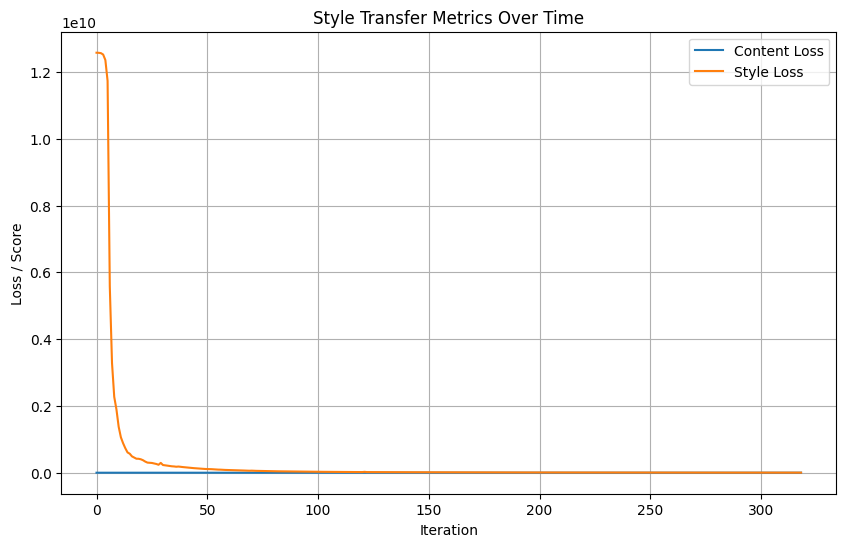


Running [18] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_1000.0_1e-06_adam_content
[10/300] Total: 13,623,783.00 | Content: 2,940,042.50 | Style: 10,655,120.00
[20/300] Total: 6,600,389.50 | Content: 2,183,200.50 | Style: 4,390,188.50
[30/300] Total: 4,040,092.00 | Content: 1,704,841.12 | Style: 2,311,396.50
[40/300] Total: 3,038,026.00 | Content: 1,368,552.38 | Style: 1,646,375.38
[50/300] Total: 2,600,844.25 | Content: 1,154,983.88 | Style: 1,422,643.62
[60/300] Total: 2,078,269.00 | Content: 1,013,287.94 | Style: 1,041,815.31
[70/300] Total: 1,842,319.00 | Content: 914,577.31 | Style: 904,755.94
[80/300] Total: 1,672,006.75 | Content: 841,255.75 | Style: 807,858.25
[90/300] Total: 1,515,532.75 | Content: 786,576.44 | Style: 706,175.12
[100/300] Total: 1,491,481.88 | Content: 753,090.06 | Style: 715,505.94
[110/300] Total: 1,475,956.38 |

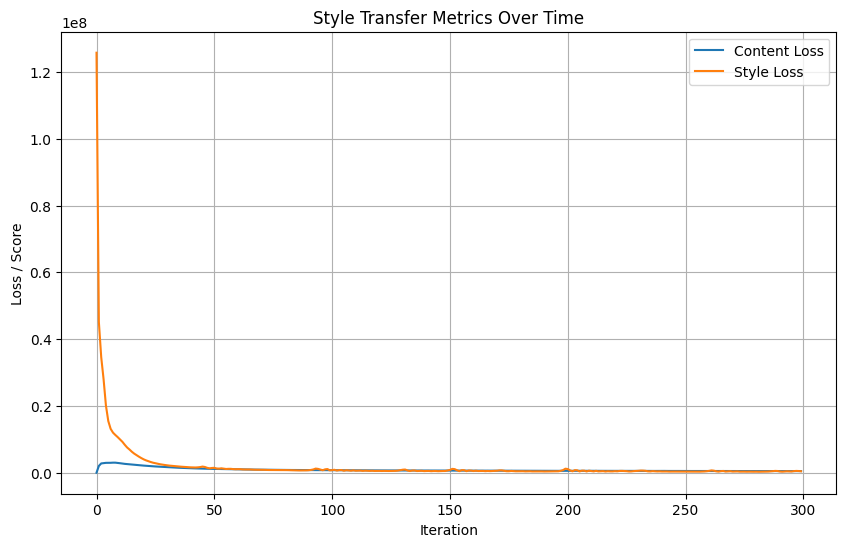


Running [19] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_1000.0_1e-06_lbfgs_content
LBFGS Step [10] Total: 21,275,604.00 | Content: 2,199,058.75 | Style: 19,061,396.00
LBFGS Step [20] Total: 6,152,370.00 | Content: 1,879,431.88 | Style: 4,256,743.50
LBFGS Step [30] Total: 3,886,042.25 | Content: 1,386,096.88 | Style: 2,484,697.25
LBFGS Step [40] Total: 2,855,796.25 | Content: 1,098,921.12 | Style: 1,741,990.88
LBFGS Step [50] Total: 2,324,164.00 | Content: 957,173.00 | Style: 1,352,760.50
LBFGS Step [60] Total: 1,833,943.62 | Content: 845,124.12 | Style: 974,908.81
LBFGS Step [70] Total: 1,494,377.88 | Content: 751,290.31 | Style: 729,353.50
LBFGS Step [80] Total: 1,293,249.12 | Content: 687,308.00 | Style: 592,466.19
LBFGS Step [90] Total: 1,155,291.38 | Content: 638,828.00 | Style: 503,187.78
LBFGS Step [100] Total: 1,062,008.50 | Conten

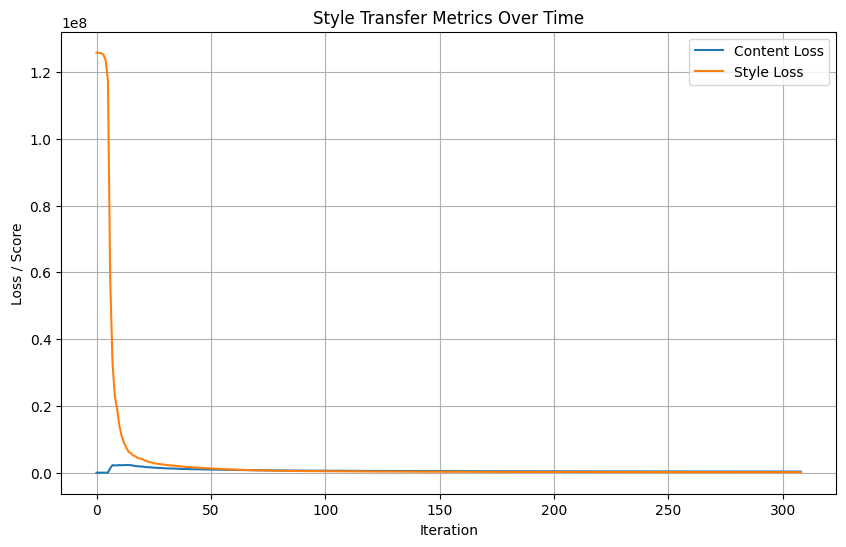


Running [20] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_1000.0_1e-05_adam_content
[10/300] Total: 13,838,223.00 | Content: 2,942,329.25 | Style: 10,612,348.00
[20/300] Total: 6,796,857.00 | Content: 2,181,246.50 | Style: 4,353,659.00
[30/300] Total: 4,229,322.50 | Content: 1,705,977.62 | Style: 2,298,901.00
[40/300] Total: 3,223,384.50 | Content: 1,369,083.12 | Style: 1,644,772.12
[50/300] Total: 2,841,597.25 | Content: 1,159,338.88 | Style: 1,479,440.88
[60/300] Total: 2,324,299.75 | Content: 1,020,090.06 | Style: 1,109,746.50
[70/300] Total: 1,998,251.75 | Content: 918,194.38 | Style: 894,471.12
[80/300] Total: 1,773,450.75 | Content: 843,527.31 | Style: 752,323.81
[90/300] Total: 2,754,117.50 | Content: 815,339.38 | Style: 1,768,966.00
[100/300] Total: 1,579,322.00 | Content: 773,483.44 | Style: 639,070.19
[110/300] Total: 1,470,768.50

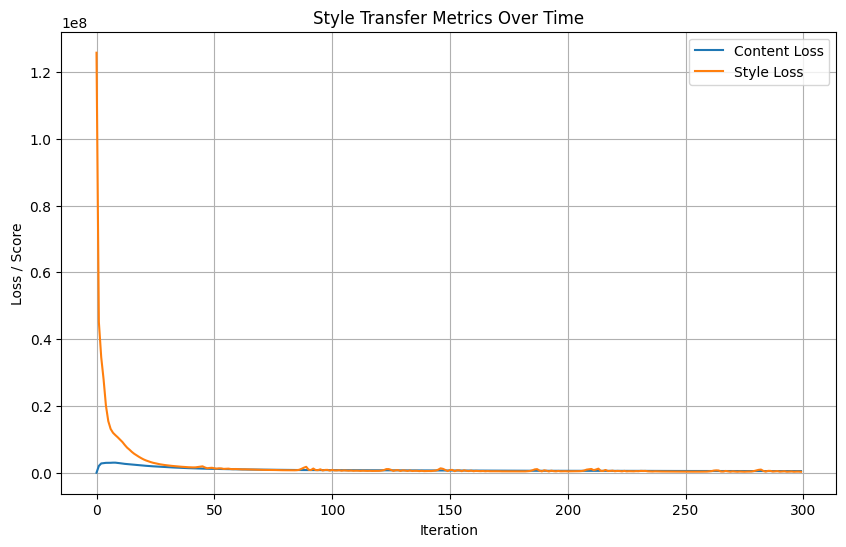


Running [21] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_1000.0_1e-05_lbfgs_content
LBFGS Step [10] Total: 21,413,220.00 | Content: 2,199,332.00 | Style: 19,062,600.00
LBFGS Step [20] Total: 6,292,320.50 | Content: 1,876,510.12 | Style: 4,256,317.00
LBFGS Step [30] Total: 4,052,055.75 | Content: 1,393,288.75 | Style: 2,511,262.00
LBFGS Step [40] Total: 3,073,563.00 | Content: 1,121,786.50 | Style: 1,809,777.50
LBFGS Step [50] Total: 2,388,830.00 | Content: 947,803.88 | Style: 1,308,916.88
LBFGS Step [60] Total: 1,908,081.38 | Content: 838,139.81 | Style: 946,787.69
LBFGS Step [70] Total: 1,570,934.88 | Content: 754,473.25 | Style: 700,205.00
LBFGS Step [80] Total: 1,395,099.25 | Content: 688,532.75 | Style: 594,788.81
LBFGS Step [90] Total: 1,249,146.50 | Content: 633,310.12 | Style: 508,298.53
LBFGS Step [100] Total: 1,148,292.38 | Conten

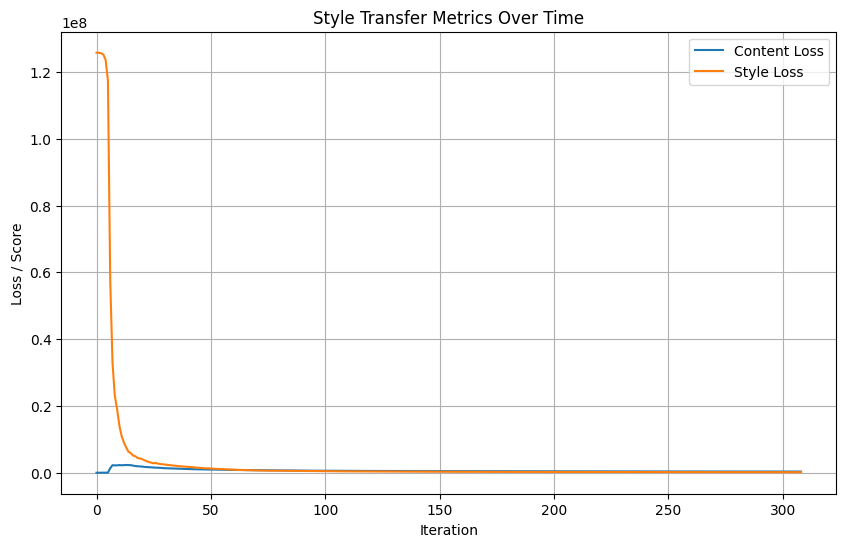


Running [22] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_1000.0_0.0001_adam_content
[10/300] Total: 15,709,608.00 | Content: 2,937,145.75 | Style: 10,177,620.00
[20/300] Total: 8,260,964.50 | Content: 2,173,325.75 | Style: 4,051,123.50
[30/300] Total: 5,412,658.50 | Content: 1,699,032.62 | Style: 2,249,656.75
[40/300] Total: 4,336,674.50 | Content: 1,368,467.12 | Style: 1,770,031.62
[50/300] Total: 3,667,861.00 | Content: 1,161,343.62 | Style: 1,442,111.38
[60/300] Total: 3,072,641.50 | Content: 1,021,555.81 | Style: 1,090,911.38
[70/300] Total: 2,732,375.75 | Content: 925,704.81 | Style: 928,052.38
[80/300] Total: 2,493,479.00 | Content: 855,415.38 | Style: 818,127.69
[90/300] Total: 2,370,219.25 | Content: 814,945.31 | Style: 770,968.19
[100/300] Total: 2,220,817.00 | Content: 775,460.94 | Style: 689,323.62
[110/300] Total: 2,103,779.75 

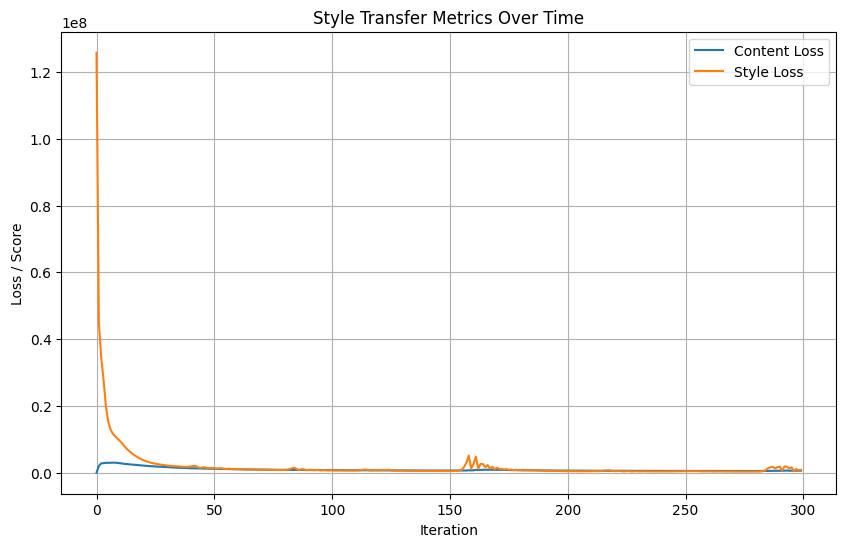


Running [23] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_1000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 22,760,044.00 | Content: 2,200,847.00 | Style: 19,067,872.00
LBFGS Step [20] Total: 7,513,919.50 | Content: 1,905,798.00 | Style: 4,207,771.00
LBFGS Step [30] Total: 5,170,088.00 | Content: 1,439,467.12 | Style: 2,592,360.00
LBFGS Step [40] Total: 3,918,780.00 | Content: 1,151,376.62 | Style: 1,796,824.38
LBFGS Step [50] Total: 3,160,248.75 | Content: 970,210.88 | Style: 1,330,020.62
LBFGS Step [60] Total: 2,667,639.00 | Content: 869,455.50 | Style: 999,781.06
LBFGS Step [70] Total: 2,285,989.25 | Content: 769,491.62 | Style: 764,146.31
LBFGS Step [80] Total: 2,072,037.25 | Content: 715,064.38 | Style: 643,146.12
LBFGS Step [90] Total: 1,881,519.00 | Content: 650,147.50 | Style: 553,906.00
LBFGS Step [100] Total: 1,753,773.00 | Conte

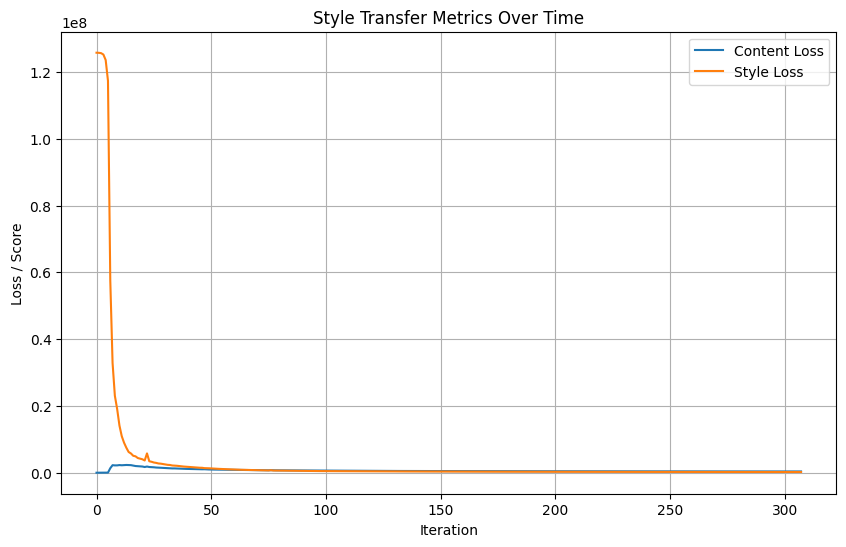


Running [24] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_10000.0_1e-06_adam_content
[10/300] Total: 110,396,016.00 | Content: 3,943,285.75 | Style: 106,424,088.00
[20/300] Total: 46,227,492.00 | Content: 3,983,215.50 | Style: 42,217,228.00
[30/300] Total: 24,870,102.00 | Content: 3,886,062.50 | Style: 20,960,222.00
[40/300] Total: 17,855,178.00 | Content: 3,671,270.50 | Style: 14,160,876.00
[50/300] Total: 13,844,579.00 | Content: 3,380,038.00 | Style: 10,441,304.00
[60/300] Total: 11,464,130.00 | Content: 3,127,103.25 | Style: 8,313,628.00
[70/300] Total: 9,892,662.00 | Content: 2,911,275.50 | Style: 6,958,029.00
[80/300] Total: 8,388,116.50 | Content: 2,714,388.50 | Style: 5,650,394.00
[90/300] Total: 7,860,712.50 | Content: 2,565,487.50 | Style: 5,271,786.50
[100/300] Total: 7,728,869.00 | Content: 2,441,658.25 | Style: 5,263,696.50
[11

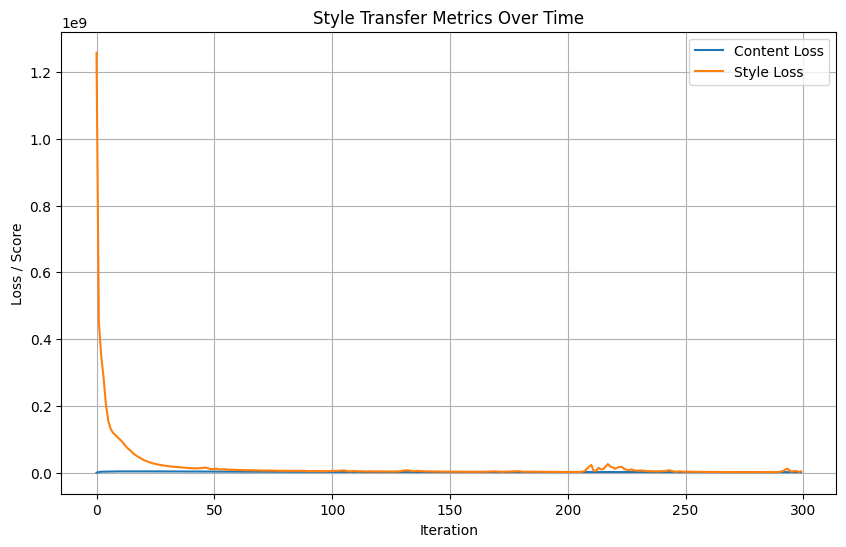


Running [25] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_10000.0_1e-06_lbfgs_content
LBFGS Step [10] Total: 192,157,456.00 | Content: 2,539,118.75 | Style: 189,603,168.00
LBFGS Step [20] Total: 44,172,980.00 | Content: 3,579,785.25 | Style: 40,576,908.00
LBFGS Step [30] Total: 25,826,410.00 | Content: 3,401,197.50 | Style: 22,410,260.00
LBFGS Step [40] Total: 20,547,906.00 | Content: 3,089,763.75 | Style: 17,443,770.00
LBFGS Step [50] Total: 15,434,164.00 | Content: 2,961,700.75 | Style: 12,458,146.00
LBFGS Step [60] Total: 11,767,494.00 | Content: 2,713,971.00 | Style: 9,039,501.00
LBFGS Step [70] Total: 8,905,333.00 | Content: 2,564,855.50 | Style: 6,326,744.50
LBFGS Step [80] Total: 7,248,868.50 | Content: 2,393,344.00 | Style: 4,842,131.50
LBFGS Step [90] Total: 6,138,752.50 | Content: 2,210,133.50 | Style: 3,915,332.50
LBFGS Step [100

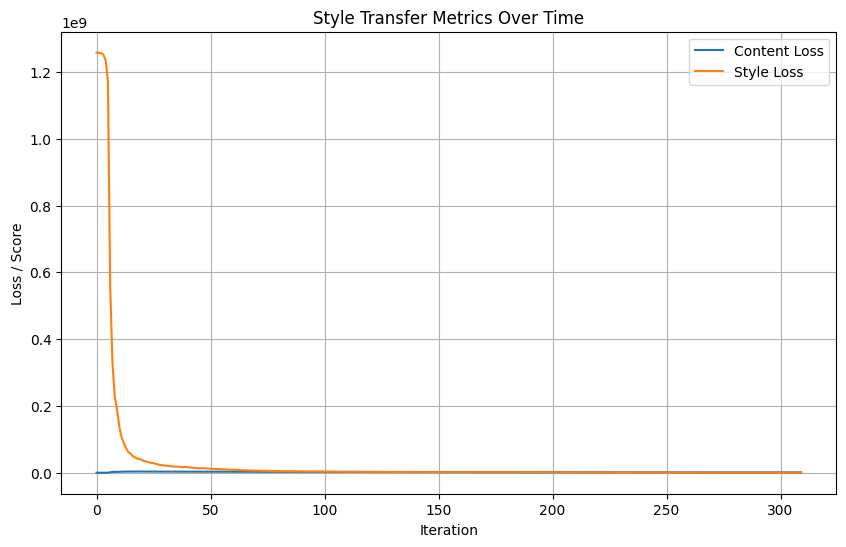


Running [26] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_10000.0_1e-05_adam_content
[10/300] Total: 110,609,032.00 | Content: 3,943,537.00 | Style: 106,379,376.00
[20/300] Total: 46,427,340.00 | Content: 3,980,733.25 | Style: 42,176,956.00
[30/300] Total: 25,062,296.00 | Content: 3,883,180.75 | Style: 20,942,452.00
[40/300] Total: 18,067,516.00 | Content: 3,668,791.75 | Style: 14,170,787.00
[50/300] Total: 14,193,927.00 | Content: 3,374,270.75 | Style: 10,590,852.00
[60/300] Total: 11,649,023.00 | Content: 3,122,568.00 | Style: 8,297,156.00
[70/300] Total: 10,084,104.00 | Content: 2,904,558.00 | Style: 6,951,954.50
[80/300] Total: 8,542,568.00 | Content: 2,713,338.25 | Style: 5,603,253.00
[90/300] Total: 8,507,309.00 | Content: 2,569,219.50 | Style: 5,712,423.50
[100/300] Total: 7,532,271.00 | Content: 2,454,585.00 | Style: 4,852,647.50
[1

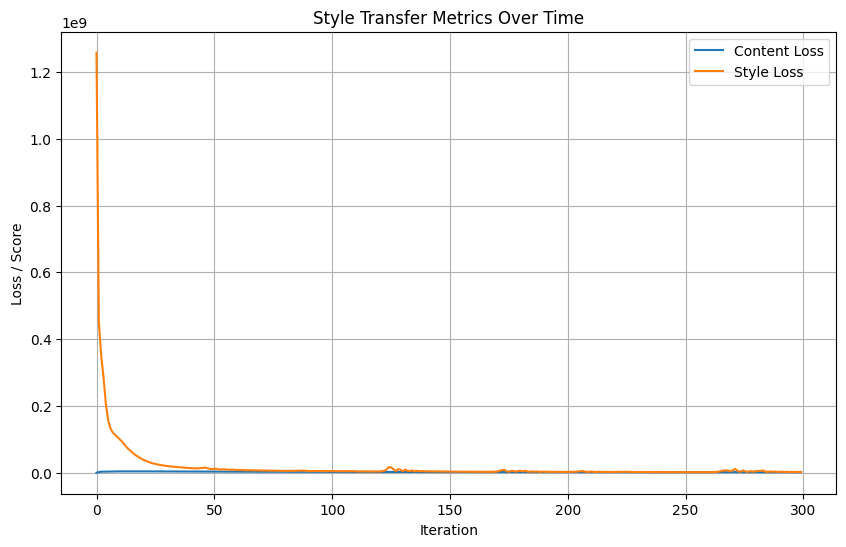


Running [27] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_10000.0_1e-05_lbfgs_content
LBFGS Step [10] Total: 192,298,992.00 | Content: 2,539,033.75 | Style: 189,608,320.00
LBFGS Step [20] Total: 44,447,960.00 | Content: 3,583,176.25 | Style: 40,702,068.00
LBFGS Step [30] Total: 25,785,558.00 | Content: 3,397,618.25 | Style: 22,239,310.00
LBFGS Step [40] Total: 19,381,540.00 | Content: 3,159,964.25 | Style: 16,077,081.00
LBFGS Step [50] Total: 14,245,483.00 | Content: 2,866,835.25 | Style: 11,238,513.00
LBFGS Step [60] Total: 10,925,993.00 | Content: 2,660,520.00 | Style: 8,128,643.50
LBFGS Step [70] Total: 8,701,209.00 | Content: 2,554,046.25 | Style: 6,013,580.50
LBFGS Step [80] Total: 7,232,650.50 | Content: 2,364,476.25 | Style: 4,736,670.00
LBFGS Step [90] Total: 6,033,087.50 | Content: 2,191,409.75 | Style: 3,712,747.25
LBFGS Step [100

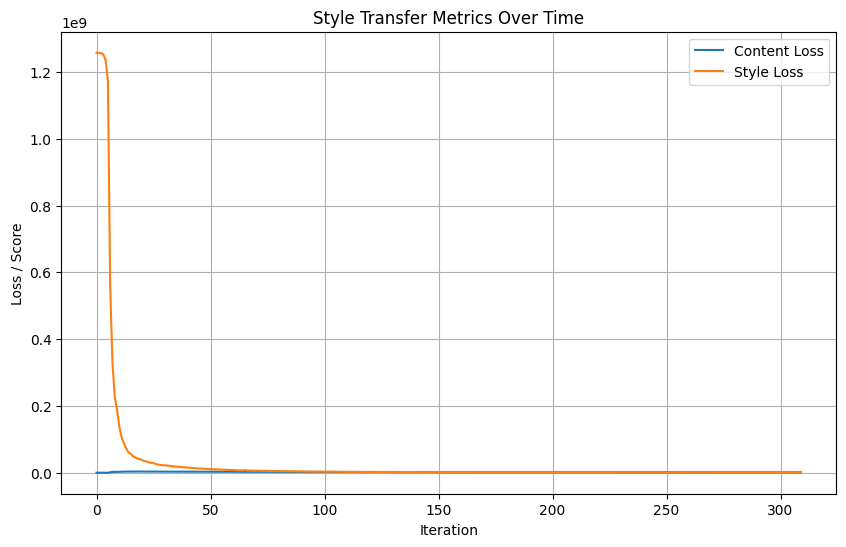


Running [28] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_10000.0_0.0001_adam_content
[10/300] Total: 112,684,840.00 | Content: 3,943,346.25 | Style: 105,906,824.00
[20/300] Total: 48,437,952.00 | Content: 3,982,285.00 | Style: 41,837,748.00
[30/300] Total: 26,978,824.00 | Content: 3,880,632.00 | Style: 20,871,894.00
[40/300] Total: 19,867,878.00 | Content: 3,661,286.75 | Style: 14,141,182.00
[50/300] Total: 15,917,219.00 | Content: 3,369,349.50 | Style: 10,553,875.00
[60/300] Total: 13,465,303.00 | Content: 3,136,906.50 | Style: 8,404,729.00
[70/300] Total: 11,559,418.00 | Content: 2,915,199.25 | Style: 6,815,494.00
[80/300] Total: 10,193,342.00 | Content: 2,725,028.50 | Style: 5,725,084.50
[90/300] Total: 10,002,365.00 | Content: 2,561,848.50 | Style: 5,772,092.00
[100/300] Total: 8,679,415.00 | Content: 2,478,281.00 | Style: 4,588,541.50

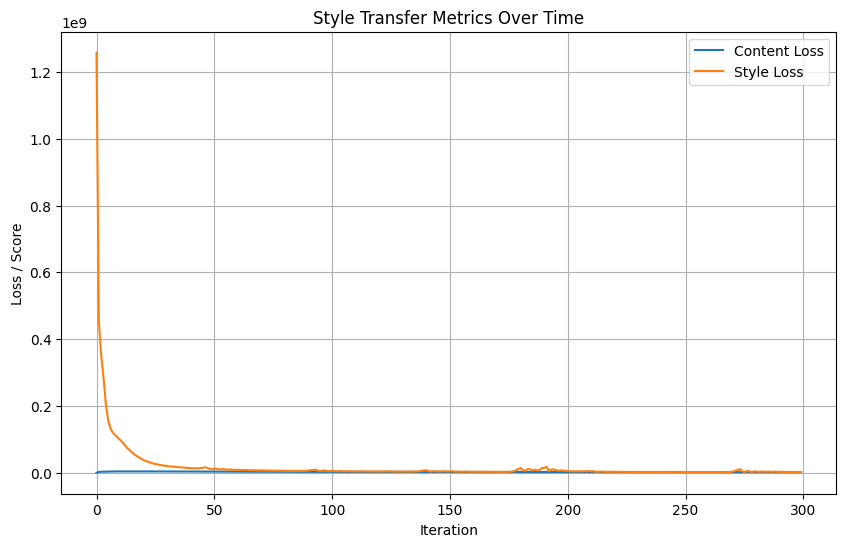


Running [29] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_10000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 193,679,968.00 | Content: 2,539,131.25 | Style: 189,626,672.00
LBFGS Step [20] Total: 45,636,184.00 | Content: 3,579,469.00 | Style: 40,454,936.00
LBFGS Step [30] Total: 27,039,768.00 | Content: 3,406,198.75 | Style: 22,201,322.00
LBFGS Step [40] Total: 19,833,330.00 | Content: 3,137,074.75 | Style: 15,345,645.00
LBFGS Step [50] Total: 15,720,265.00 | Content: 2,829,016.25 | Style: 11,616,710.00
LBFGS Step [60] Total: 12,707,720.00 | Content: 2,650,401.50 | Style: 8,848,547.00
LBFGS Step [70] Total: 10,103,056.00 | Content: 2,540,190.00 | Style: 6,403,223.00
LBFGS Step [80] Total: 8,329,386.00 | Content: 2,336,080.00 | Style: 4,901,216.00
LBFGS Step [90] Total: 7,190,927.00 | Content: 2,210,222.75 | Style: 3,937,656.00
LBFGS Step [1

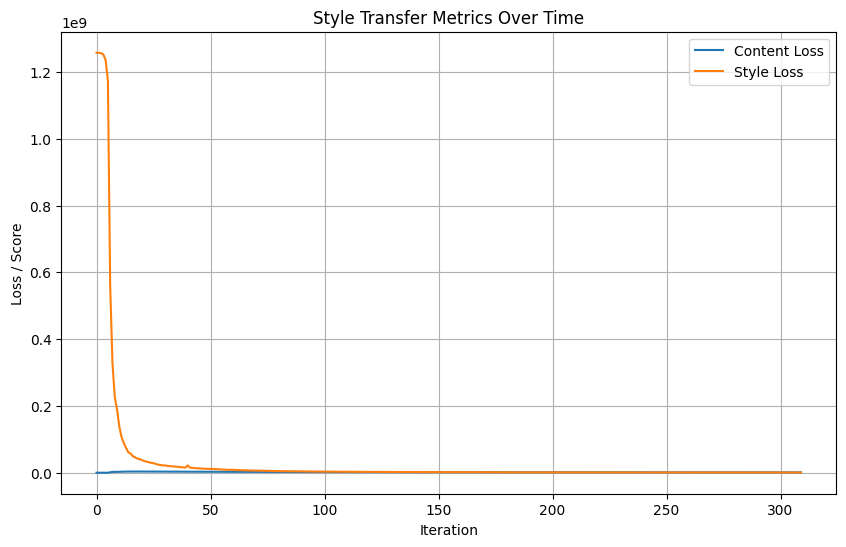


Running [30] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_100000.0_1e-06_adam_content
[10/300] Total: 1,069,689,280.00 | Content: 4,047,918.25 | Style: 1,065,612,672.00
[20/300] Total: 426,673,984.00 | Content: 4,252,848.50 | Style: 422,394,048.00
[30/300] Total: 213,294,928.00 | Content: 4,410,053.50 | Style: 208,861,040.00
[40/300] Total: 145,363,648.00 | Content: 4,508,707.00 | Style: 140,831,888.00
[50/300] Total: 107,642,040.00 | Content: 4,500,032.50 | Style: 103,118,744.00
[60/300] Total: 86,683,088.00 | Content: 4,480,507.50 | Style: 82,179,152.00
[70/300] Total: 69,491,640.00 | Content: 4,472,619.50 | Style: 64,995,612.00
[80/300] Total: 57,319,200.00 | Content: 4,428,610.00 | Style: 52,867,196.00
[90/300] Total: 71,498,088.00 | Content: 4,424,624.50 | Style: 67,049,920.00
[100/300] Total: 49,717,232.00 | Content: 4,392,648.50 | St

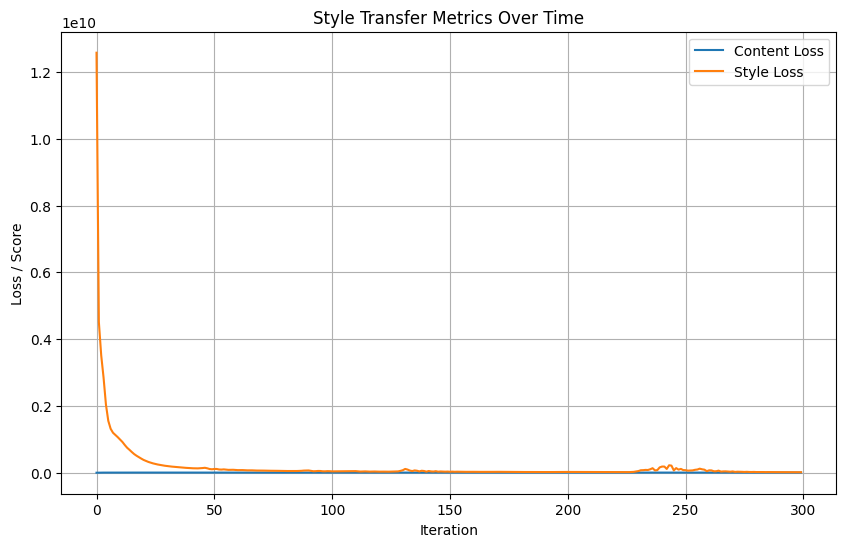


Running [31] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_100000.0_1e-06_lbfgs_content
LBFGS Step [10] Total: 1,897,426,944.00 | Content: 2,576,478.00 | Style: 1,894,835,328.00
LBFGS Step [20] Total: 422,148,960.00 | Content: 3,878,466.25 | Style: 418,254,208.00
LBFGS Step [30] Total: 229,651,392.00 | Content: 4,042,845.00 | Style: 225,593,648.00
LBFGS Step [40] Total: 170,338,960.00 | Content: 4,201,044.00 | Style: 166,123,296.00
LBFGS Step [50] Total: 123,453,488.00 | Content: 4,176,708.50 | Style: 119,262,416.00
LBFGS Step [60] Total: 88,674,088.00 | Content: 4,204,642.00 | Style: 84,455,584.00
LBFGS Step [70] Total: 66,629,648.00 | Content: 4,258,854.00 | Style: 62,357,152.00
LBFGS Step [80] Total: 49,431,536.00 | Content: 4,286,009.50 | Style: 45,131,996.00
LBFGS Step [90] Total: 39,633,864.00 | Content: 4,266,002.50 | Style: 35,354,56

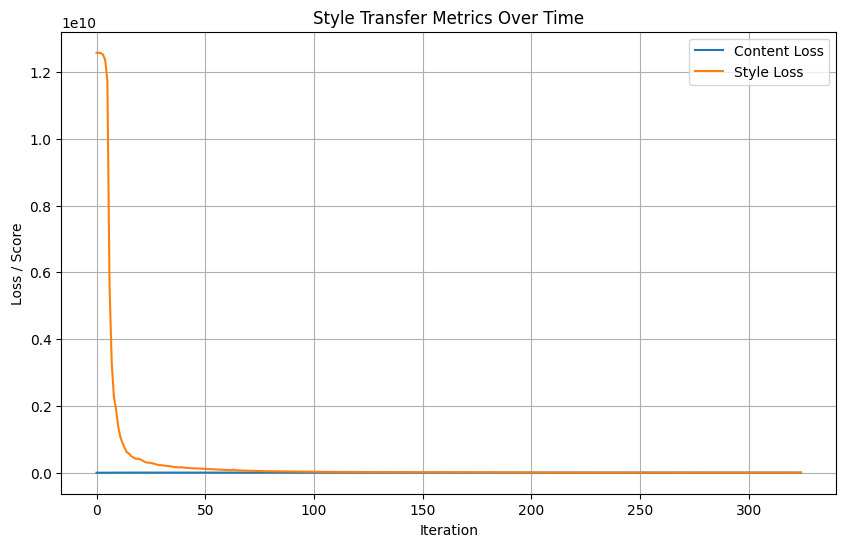


Running [32] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_100000.0_1e-05_adam_content
[10/300] Total: 1,069,791,808.00 | Content: 4,047,376.25 | Style: 1,065,458,048.00
[20/300] Total: 426,753,472.00 | Content: 4,253,780.00 | Style: 422,229,056.00
[30/300] Total: 213,473,792.00 | Content: 4,409,076.50 | Style: 208,826,464.00
[40/300] Total: 145,432,672.00 | Content: 4,507,636.50 | Style: 140,694,768.00
[50/300] Total: 107,998,760.00 | Content: 4,503,585.00 | Style: 103,262,848.00
[60/300] Total: 85,158,064.00 | Content: 4,490,409.00 | Style: 80,433,696.00
[70/300] Total: 71,269,792.00 | Content: 4,481,418.50 | Style: 66,554,896.00
[80/300] Total: 58,802,588.00 | Content: 4,441,100.00 | Style: 54,128,256.00
[90/300] Total: 49,824,968.00 | Content: 4,398,067.50 | Style: 45,192,900.00
[100/300] Total: 125,025,600.00 | Content: 4,427,483.50 | S

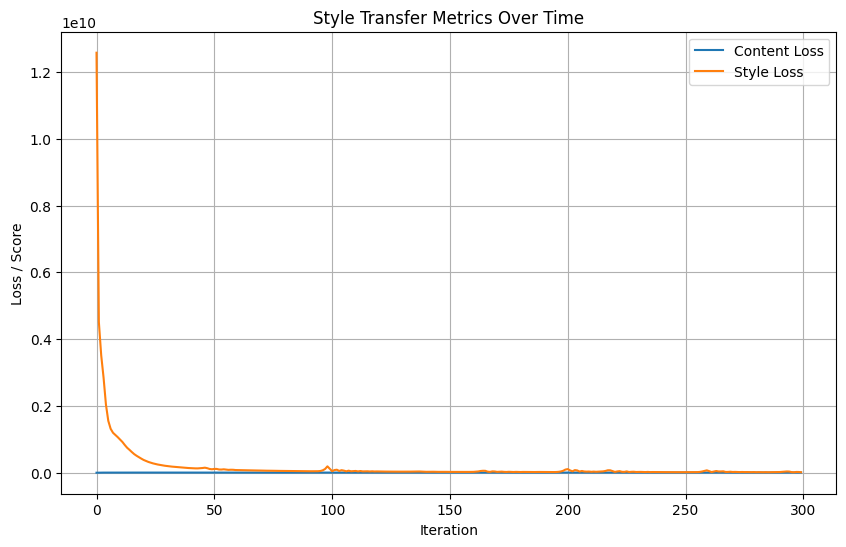


Running [33] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_100000.0_1e-05_lbfgs_content
LBFGS Step [10] Total: 1,897,609,856.00 | Content: 2,576,462.75 | Style: 1,894,881,664.00
LBFGS Step [20] Total: 422,817,088.00 | Content: 3,881,407.50 | Style: 418,772,736.00
LBFGS Step [30] Total: 231,037,840.00 | Content: 4,034,550.25 | Style: 226,854,976.00
LBFGS Step [40] Total: 155,675,712.00 | Content: 4,174,002.00 | Style: 151,356,816.00
LBFGS Step [50] Total: 115,786,168.00 | Content: 4,223,623.50 | Style: 111,420,656.00
LBFGS Step [60] Total: 84,318,096.00 | Content: 4,247,845.50 | Style: 79,932,776.00
LBFGS Step [70] Total: 64,465,832.00 | Content: 4,262,504.50 | Style: 60,067,560.00
LBFGS Step [80] Total: 48,251,036.00 | Content: 4,252,321.00 | Style: 43,864,120.00
LBFGS Step [90] Total: 40,037,748.00 | Content: 4,220,739.50 | Style: 35,683,72

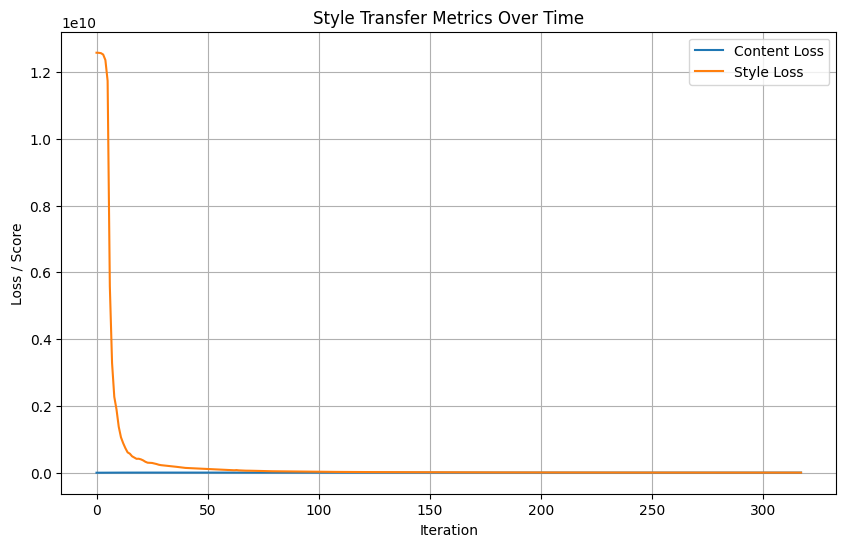


Running [34] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_100000.0_0.0001_adam_content
[10/300] Total: 1,071,993,280.00 | Content: 4,047,769.00 | Style: 1,065,084,480.00
[20/300] Total: 428,860,736.00 | Content: 4,254,429.50 | Style: 421,908,320.00
[30/300] Total: 215,418,576.00 | Content: 4,410,621.50 | Style: 208,641,008.00
[40/300] Total: 147,644,352.00 | Content: 4,509,606.00 | Style: 140,856,176.00
[50/300] Total: 110,752,768.00 | Content: 4,503,561.50 | Style: 103,961,976.00
[60/300] Total: 88,376,088.00 | Content: 4,487,456.00 | Style: 81,597,336.00
[70/300] Total: 71,990,624.00 | Content: 4,477,541.00 | Style: 65,239,244.00
[80/300] Total: 59,437,208.00 | Content: 4,431,892.50 | Style: 52,748,568.00
[90/300] Total: 75,113,160.00 | Content: 4,427,216.50 | Style: 68,430,336.00
[100/300] Total: 52,046,636.00 | Content: 4,383,750.50 | S

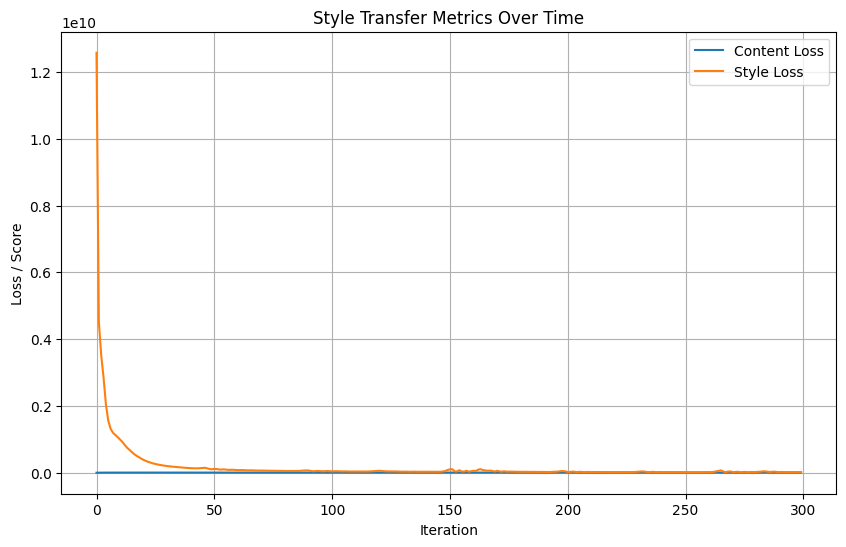


Running [35] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_1000.0_100000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 1,899,019,264.00 | Content: 2,576,572.50 | Style: 1,894,926,208.00
LBFGS Step [20] Total: 424,120,768.00 | Content: 3,876,906.00 | Style: 418,617,280.00
LBFGS Step [30] Total: 233,499,552.00 | Content: 4,031,211.75 | Style: 227,991,776.00
LBFGS Step [40] Total: 158,127,024.00 | Content: 4,143,308.00 | Style: 152,543,936.00
LBFGS Step [50] Total: 116,044,208.00 | Content: 4,206,274.50 | Style: 110,432,848.00
LBFGS Step [60] Total: 89,012,160.00 | Content: 4,233,613.50 | Style: 83,410,232.00
LBFGS Step [70] Total: 65,636,008.00 | Content: 4,287,040.50 | Style: 60,015,648.00
LBFGS Step [80] Total: 51,404,124.00 | Content: 4,299,492.50 | Style: 45,792,748.00
LBFGS Step [90] Total: 41,554,020.00 | Content: 4,251,898.50 | Style: 36,014,2

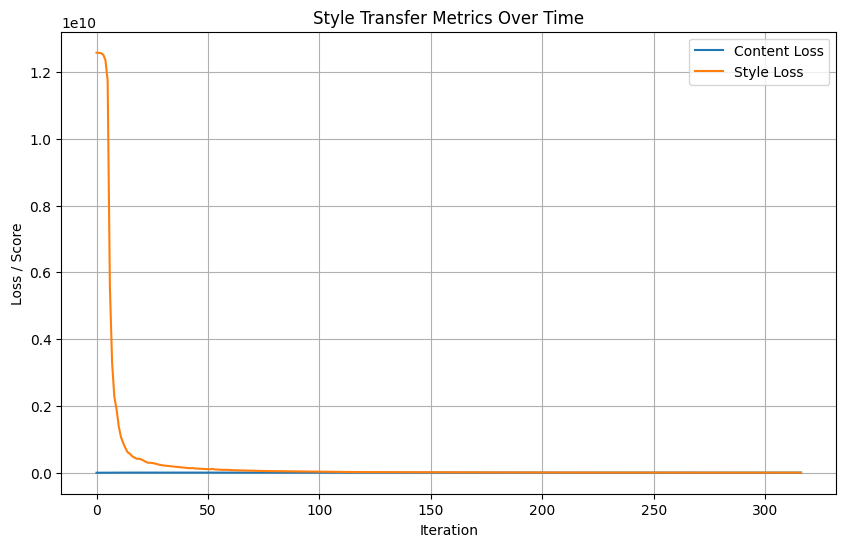


Running [36] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_1000.0_1e-06_adam_content
[10/300] Total: 23,006,178.00 | Content: 10,082,662.00 | Style: 12,895,821.00
[20/300] Total: 12,648,117.00 | Content: 6,239,535.00 | Style: 6,382,122.50
[30/300] Total: 8,305,656.50 | Content: 4,561,215.00 | Style: 3,720,933.50
[40/300] Total: 6,375,923.50 | Content: 3,581,935.00 | Style: 2,771,555.00
[50/300] Total: 5,582,889.00 | Content: 3,057,901.00 | Style: 2,502,708.50
[60/300] Total: 4,710,646.50 | Content: 2,669,269.75 | Style: 2,019,177.12
[70/300] Total: 4,179,697.25 | Content: 2,418,566.75 | Style: 1,739,080.25
[80/300] Total: 4,319,862.00 | Content: 2,345,585.75 | Style: 1,952,270.50
[90/300] Total: 3,780,567.50 | Content: 2,260,098.25 | Style: 1,498,388.38
[100/300] Total: 3,530,438.25 | Content: 2,096,341.00 | Style: 1,412,075.25
[110/300] To

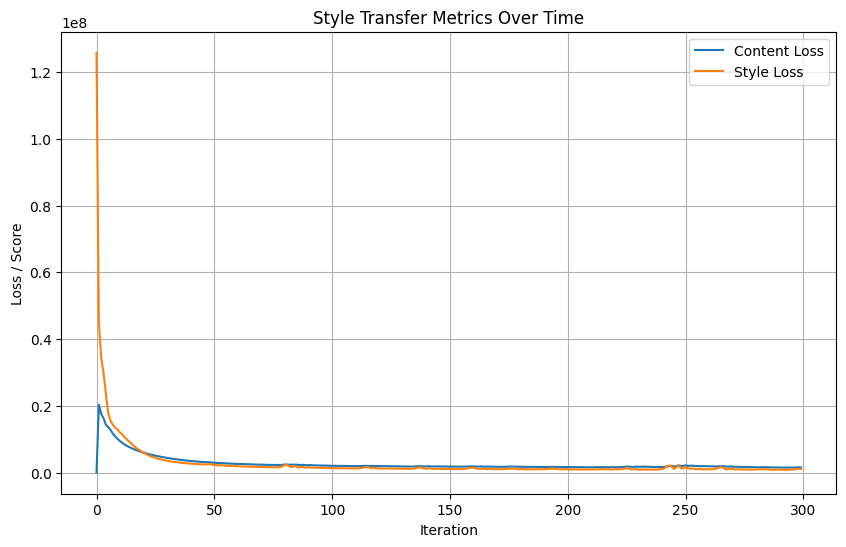


Running [37] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_1000.0_1e-06_lbfgs_content
LBFGS Step [10] Total: 30,182,260.00 | Content: 10,208,038.00 | Style: 19,958,780.00
LBFGS Step [20] Total: 11,776,947.00 | Content: 5,330,613.50 | Style: 6,429,806.50
LBFGS Step [30] Total: 8,111,771.50 | Content: 3,930,500.75 | Style: 4,165,005.00
LBFGS Step [40] Total: 6,372,568.00 | Content: 3,155,186.50 | Style: 3,201,601.75
LBFGS Step [50] Total: 5,380,342.00 | Content: 2,738,209.50 | Style: 2,626,788.75
LBFGS Step [60] Total: 4,680,914.50 | Content: 2,424,686.25 | Style: 2,241,165.50
LBFGS Step [70] Total: 4,184,005.50 | Content: 2,218,557.25 | Style: 1,950,526.38
LBFGS Step [80] Total: 3,797,106.75 | Content: 2,068,605.50 | Style: 1,713,726.50
LBFGS Step [90] Total: 3,506,238.50 | Content: 1,950,043.38 | Style: 1,541,518.62
LBFGS Step [100] Total: 

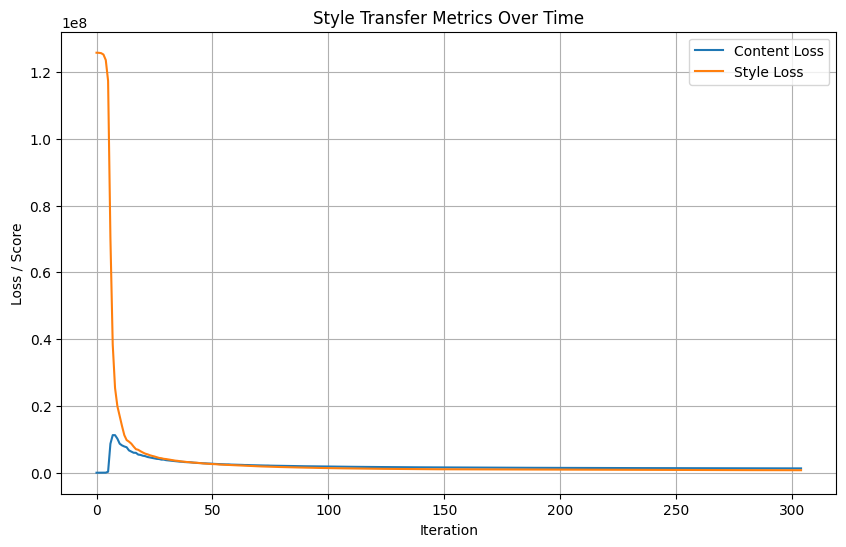


Running [38] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_1000.0_1e-05_adam_content
[10/300] Total: 23,201,432.00 | Content: 10,087,145.00 | Style: 12,839,654.00
[20/300] Total: 12,852,262.00 | Content: 6,251,241.00 | Style: 6,342,852.00
[30/300] Total: 8,489,355.00 | Content: 4,558,221.50 | Style: 3,707,047.25
[40/300] Total: 6,548,506.50 | Content: 3,578,260.75 | Style: 2,762,278.25
[50/300] Total: 5,917,098.50 | Content: 3,097,121.00 | Style: 2,619,305.00
[60/300] Total: 4,823,635.50 | Content: 2,673,927.00 | Style: 1,955,564.50
[70/300] Total: 4,349,156.00 | Content: 2,428,834.75 | Style: 1,732,969.38
[80/300] Total: 4,473,588.00 | Content: 2,367,402.75 | Style: 1,925,851.75
[90/300] Total: 3,857,760.75 | Content: 2,202,104.25 | Style: 1,479,711.12
[100/300] Total: 3,689,977.00 | Content: 2,106,178.50 | Style: 1,412,609.50
[110/300] To

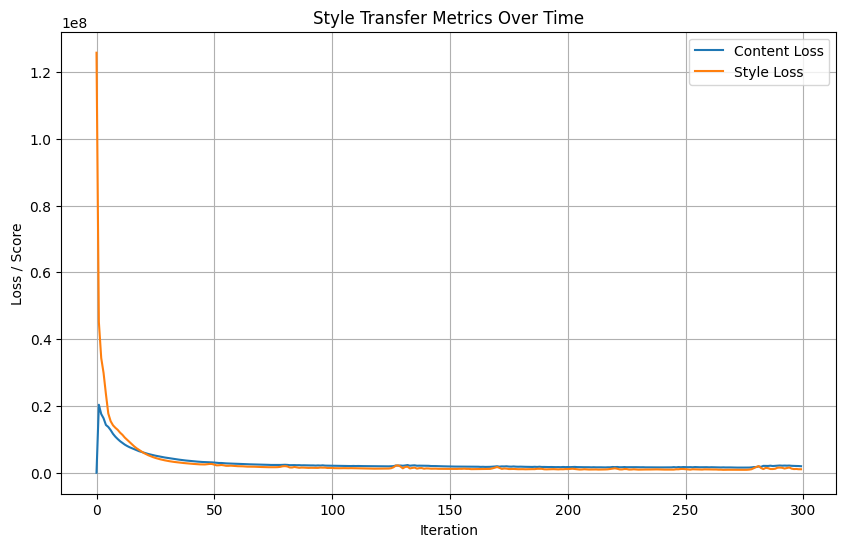


Running [39] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_1000.0_1e-05_lbfgs_content
LBFGS Step [10] Total: 30,318,904.00 | Content: 10,204,504.00 | Style: 19,960,236.00
LBFGS Step [20] Total: 11,968,994.00 | Content: 5,346,415.50 | Style: 6,459,158.00
LBFGS Step [30] Total: 8,253,943.50 | Content: 3,841,067.00 | Style: 4,254,536.50
LBFGS Step [40] Total: 6,509,207.50 | Content: 3,170,599.75 | Style: 3,187,180.25
LBFGS Step [50] Total: 5,514,696.50 | Content: 2,710,640.25 | Style: 2,659,728.00
LBFGS Step [60] Total: 4,857,550.50 | Content: 2,473,634.50 | Style: 2,244,380.25
LBFGS Step [70] Total: 4,342,866.00 | Content: 2,240,954.00 | Style: 1,965,880.50
LBFGS Step [80] Total: 3,958,070.75 | Content: 2,091,329.75 | Style: 1,733,801.12
LBFGS Step [90] Total: 3,648,747.50 | Content: 1,969,798.00 | Style: 1,549,318.50
LBFGS Step [100] Total: 

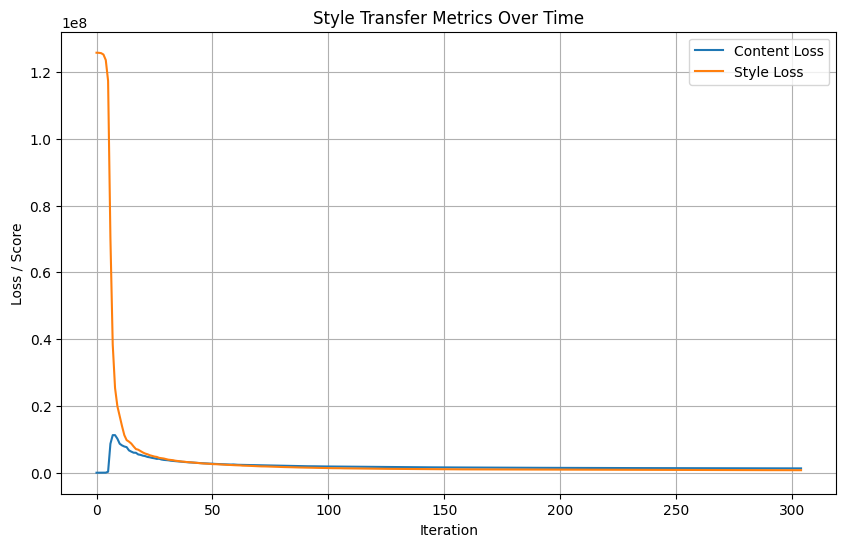


Running [40] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_1000.0_0.0001_adam_content
[10/300] Total: 25,099,000.00 | Content: 10,112,359.00 | Style: 12,451,412.00
[20/300] Total: 14,332,678.00 | Content: 6,228,786.00 | Style: 6,018,559.50
[30/300] Total: 9,704,518.00 | Content: 4,535,580.00 | Style: 3,597,849.50
[40/300] Total: 7,626,850.50 | Content: 3,577,698.00 | Style: 2,747,893.00
[50/300] Total: 6,430,785.00 | Content: 3,006,750.75 | Style: 2,269,735.50
[60/300] Total: 5,708,902.50 | Content: 2,687,756.00 | Style: 1,966,492.38
[70/300] Total: 5,266,842.00 | Content: 2,483,276.50 | Style: 1,804,891.75
[80/300] Total: 5,008,109.50 | Content: 2,334,204.50 | Style: 1,750,863.88
[90/300] Total: 4,636,038.50 | Content: 2,239,170.75 | Style: 1,515,580.62
[100/300] Total: 4,467,782.50 | Content: 2,162,364.75 | Style: 1,453,345.25
[110/300] T

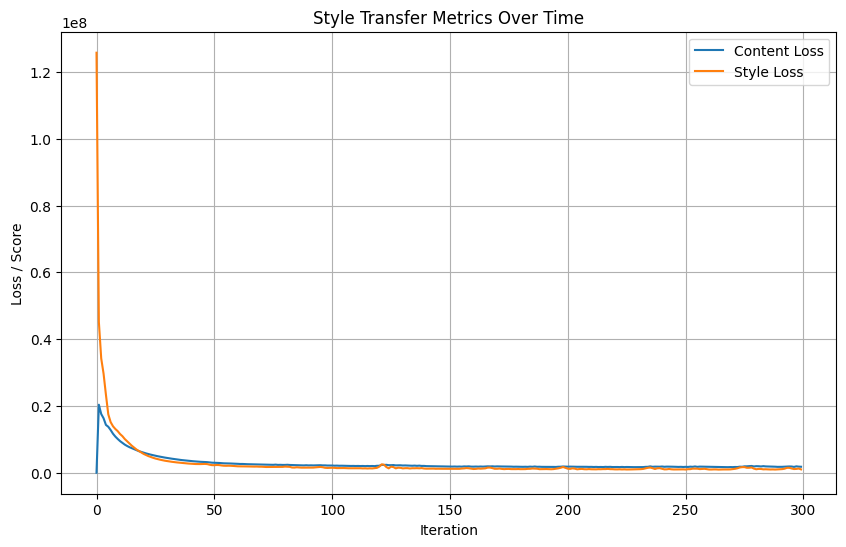


Running [41] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_1000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 31,671,844.00 | Content: 10,207,290.00 | Style: 19,946,524.00
LBFGS Step [20] Total: 13,211,421.00 | Content: 5,378,891.50 | Style: 6,362,223.50
LBFGS Step [30] Total: 9,259,622.00 | Content: 3,904,217.75 | Style: 4,079,748.00
LBFGS Step [40] Total: 7,447,147.00 | Content: 3,161,674.50 | Style: 3,166,301.00
LBFGS Step [50] Total: 6,361,570.00 | Content: 2,745,901.75 | Style: 2,609,170.75
LBFGS Step [60] Total: 5,628,688.50 | Content: 2,454,268.25 | Style: 2,233,438.75
LBFGS Step [70] Total: 5,092,199.50 | Content: 2,249,303.00 | Style: 1,943,740.38
LBFGS Step [80] Total: 4,680,162.50 | Content: 2,099,801.50 | Style: 1,711,775.25
LBFGS Step [90] Total: 4,352,410.50 | Content: 1,988,400.12 | Style: 1,523,660.50
LBFGS Step [100] Total:

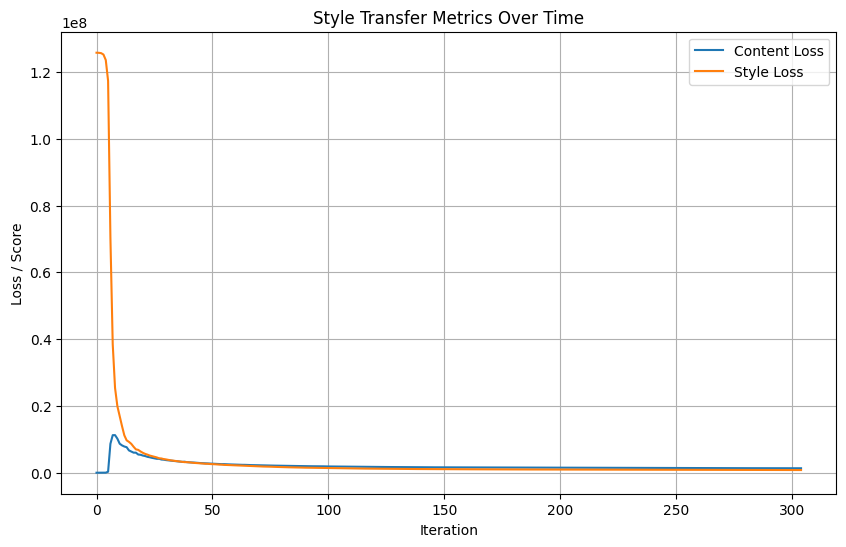


Running [42] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_10000.0_1e-06_adam_content
[10/300] Total: 136,040,928.00 | Content: 29,393,892.00 | Style: 106,618,384.00
[20/300] Total: 65,769,640.00 | Content: 21,792,634.00 | Style: 43,949,920.00
[30/300] Total: 40,197,000.00 | Content: 17,050,560.00 | Style: 23,122,424.00
[40/300] Total: 30,182,938.00 | Content: 13,694,062.00 | Style: 16,465,535.00
[50/300] Total: 25,515,970.00 | Content: 11,566,375.00 | Style: 13,926,031.00
[60/300] Total: 20,598,686.00 | Content: 10,167,440.00 | Style: 10,407,609.00
[70/300] Total: 18,269,026.00 | Content: 9,171,516.00 | Style: 9,073,928.00
[80/300] Total: 16,300,816.00 | Content: 8,422,263.00 | Style: 7,854,926.00
[90/300] Total: 14,789,802.00 | Content: 7,867,314.00 | Style: 6,898,822.00
[100/300] Total: 15,872,536.00 | Content: 7,725,864.50 | Style: 8,12

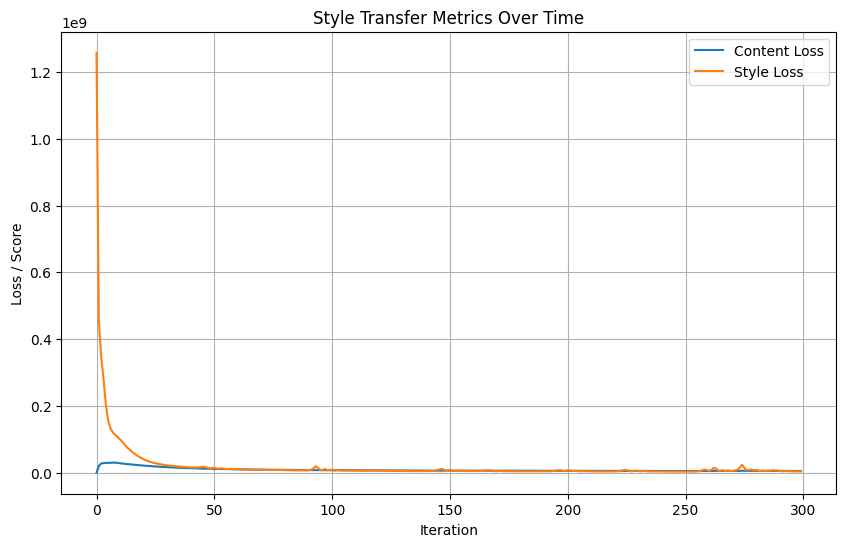


Running [43] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_10000.0_1e-06_lbfgs_content
LBFGS Step [10] Total: 212,625,264.00 | Content: 21,990,672.00 | Style: 190,619,440.00
LBFGS Step [20] Total: 61,438,440.00 | Content: 18,807,354.00 | Style: 42,614,868.00
LBFGS Step [30] Total: 38,923,852.00 | Content: 13,904,894.00 | Style: 25,003,660.00
LBFGS Step [40] Total: 28,804,994.00 | Content: 10,777,045.00 | Style: 18,012,898.00
LBFGS Step [50] Total: 22,359,748.00 | Content: 9,445,105.00 | Style: 12,900,212.00
LBFGS Step [60] Total: 18,268,474.00 | Content: 8,459,774.00 | Style: 9,794,554.00
LBFGS Step [70] Total: 15,305,649.00 | Content: 7,644,986.00 | Style: 7,646,685.50
LBFGS Step [80] Total: 13,247,454.00 | Content: 7,019,984.00 | Style: 6,213,710.00
LBFGS Step [90] Total: 11,808,878.00 | Content: 6,502,881.50 | Style: 5,292,356.00
LBFGS S

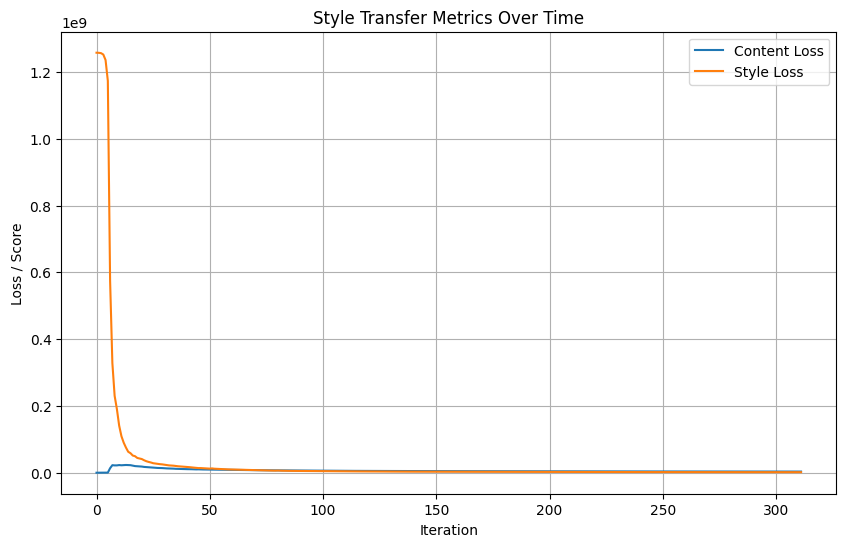


Running [44] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_10000.0_1e-05_adam_content
[10/300] Total: 136,241,552.00 | Content: 29,401,550.00 | Style: 106,553,792.00
[20/300] Total: 65,988,924.00 | Content: 21,814,804.00 | Style: 43,904,116.00
[30/300] Total: 40,397,184.00 | Content: 17,034,866.00 | Style: 23,123,748.00
[40/300] Total: 30,381,078.00 | Content: 13,681,709.00 | Style: 16,468,389.00
[50/300] Total: 25,988,540.00 | Content: 11,555,868.00 | Style: 14,200,540.00
[60/300] Total: 20,769,272.00 | Content: 10,130,211.00 | Style: 10,407,458.00
[70/300] Total: 18,399,780.00 | Content: 9,148,642.00 | Style: 9,021,267.00
[80/300] Total: 16,752,695.00 | Content: 8,407,125.00 | Style: 8,116,557.00
[90/300] Total: 15,047,911.00 | Content: 7,872,623.50 | Style: 6,947,269.00
[100/300] Total: 15,743,633.00 | Content: 7,590,567.50 | Style: 7,92

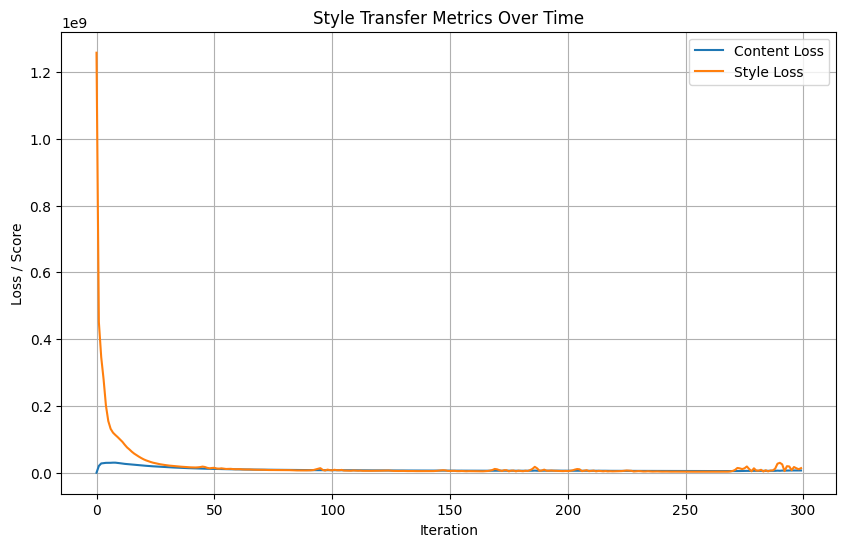


Running [45] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_10000.0_1e-05_lbfgs_content
LBFGS Step [10] Total: 212,755,552.00 | Content: 21,991,492.00 | Style: 190,612,560.00
LBFGS Step [20] Total: 61,512,136.00 | Content: 18,776,062.00 | Style: 42,574,220.00
LBFGS Step [30] Total: 39,045,340.00 | Content: 13,904,631.00 | Style: 24,987,828.00
LBFGS Step [40] Total: 28,384,924.00 | Content: 10,989,395.00 | Style: 17,246,876.00
LBFGS Step [50] Total: 22,422,444.00 | Content: 9,520,985.00 | Style: 12,758,407.00
LBFGS Step [60] Total: 18,109,000.00 | Content: 8,414,281.00 | Style: 9,555,374.00
LBFGS Step [70] Total: 15,216,651.00 | Content: 7,607,791.00 | Style: 7,471,708.50
LBFGS Step [80] Total: 12,945,196.00 | Content: 6,846,238.00 | Style: 5,963,972.50
LBFGS Step [90] Total: 11,587,180.00 | Content: 6,366,292.50 | Style: 5,087,714.50
LBFGS S

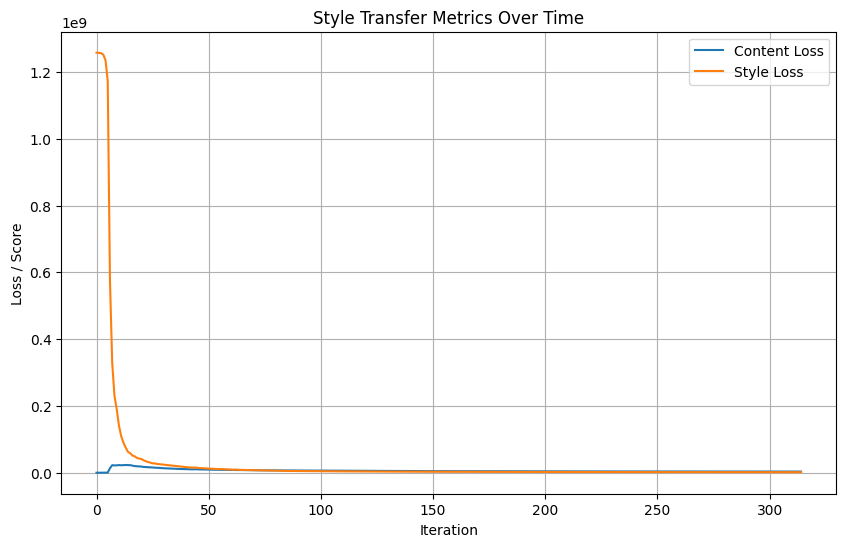


Running [46] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_10000.0_0.0001_adam_content
[10/300] Total: 138,378,560.00 | Content: 29,425,388.00 | Style: 106,117,744.00
[20/300] Total: 67,986,184.00 | Content: 21,814,656.00 | Style: 43,552,020.00
[30/300] Total: 42,307,380.00 | Content: 17,075,540.00 | Style: 22,987,860.00
[40/300] Total: 32,245,506.00 | Content: 13,694,956.00 | Style: 16,455,441.00
[50/300] Total: 28,390,194.00 | Content: 11,584,858.00 | Style: 14,777,829.00
[60/300] Total: 23,026,094.00 | Content: 10,183,054.00 | Style: 10,898,865.00
[70/300] Total: 20,102,780.00 | Content: 9,186,066.00 | Style: 9,061,382.00
[80/300] Total: 17,886,778.00 | Content: 8,445,916.00 | Style: 7,663,974.50
[90/300] Total: 16,276,830.00 | Content: 7,878,224.50 | Style: 6,695,111.00
[100/300] Total: 19,116,896.00 | Content: 8,089,778.50 | Style: 9,3

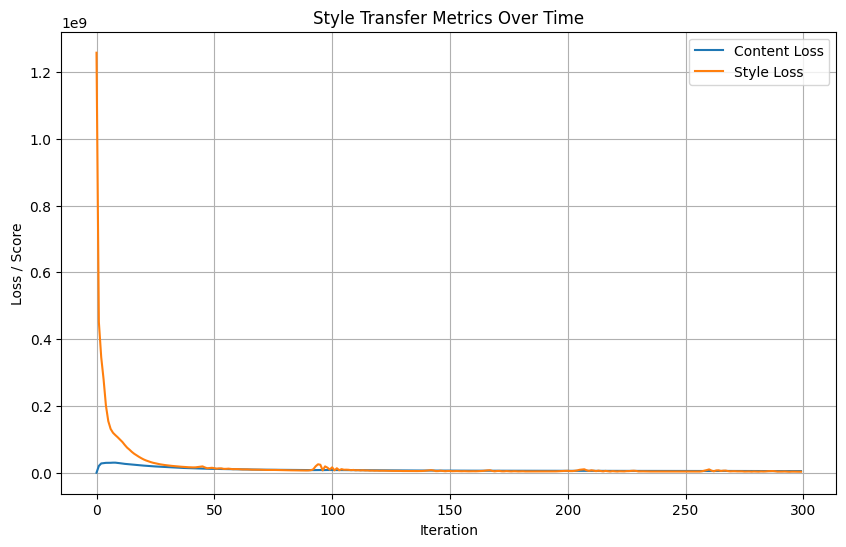


Running [47] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_10000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 214,130,672.00 | Content: 21,993,208.00 | Style: 190,624,592.00
LBFGS Step [20] Total: 62,906,336.00 | Content: 18,733,638.00 | Style: 42,578,756.00
LBFGS Step [30] Total: 40,795,012.00 | Content: 14,132,235.00 | Style: 25,185,782.00
LBFGS Step [40] Total: 30,753,310.00 | Content: 11,163,718.00 | Style: 18,181,106.00
LBFGS Step [50] Total: 23,616,914.00 | Content: 9,517,040.00 | Style: 12,800,777.00
LBFGS Step [60] Total: 18,879,518.00 | Content: 8,432,578.00 | Style: 9,221,979.00
LBFGS Step [70] Total: 15,969,111.00 | Content: 7,466,734.00 | Style: 7,329,861.00
LBFGS Step [80] Total: 13,994,568.00 | Content: 6,969,978.00 | Style: 5,903,995.00
LBFGS Step [90] Total: 12,439,375.00 | Content: 6,306,344.50 | Style: 5,060,219.50
LBFGS 

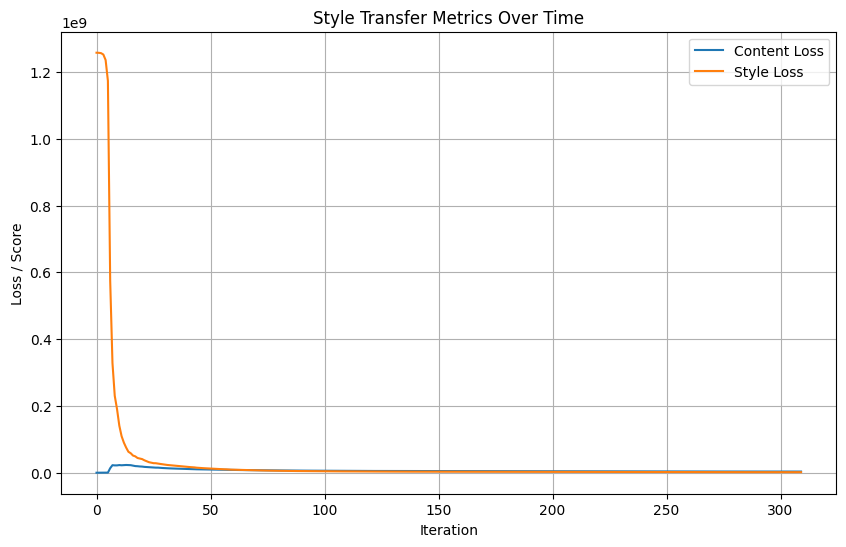


Running [48] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_100000.0_1e-06_adam_content
[10/300] Total: 1,103,806,848.00 | Content: 39,432,792.00 | Style: 1,064,345,408.00
[20/300] Total: 462,038,112.00 | Content: 39,818,320.00 | Style: 422,192,736.00
[30/300] Total: 248,452,160.00 | Content: 38,845,456.00 | Style: 209,582,864.00
[40/300] Total: 178,282,208.00 | Content: 36,725,728.00 | Style: 141,533,424.00
[50/300] Total: 137,910,336.00 | Content: 33,809,452.00 | Style: 104,077,600.00
[60/300] Total: 114,755,824.00 | Content: 31,293,930.00 | Style: 83,438,448.00
[70/300] Total: 98,772,360.00 | Content: 29,088,210.00 | Style: 69,660,720.00
[80/300] Total: 83,734,728.00 | Content: 27,138,144.00 | Style: 56,573,160.00
[90/300] Total: 80,115,080.00 | Content: 25,636,336.00 | Style: 54,455,208.00
[100/300] Total: 79,053,032.00 | Content: 24,391

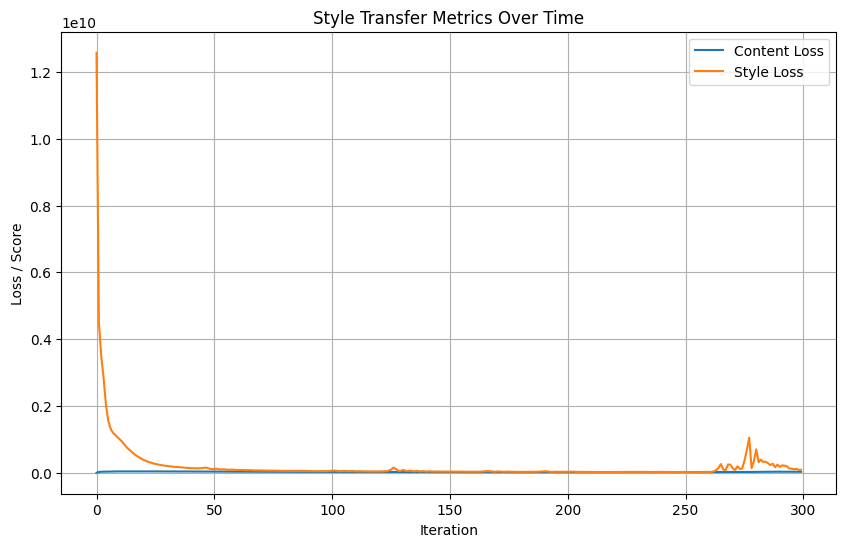


Running [49] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_100000.0_1e-06_lbfgs_content
LBFGS Step [10] Total: 1,921,429,376.00 | Content: 25,390,782.00 | Style: 1,896,023,552.00
LBFGS Step [20] Total: 442,033,056.00 | Content: 35,806,272.00 | Style: 406,210,496.00
LBFGS Step [30] Total: 256,709,552.00 | Content: 34,033,784.00 | Style: 222,660,816.00
LBFGS Step [40] Total: 232,169,920.00 | Content: 31,524,456.00 | Style: 200,630,896.00
LBFGS Step [50] Total: 156,106,000.00 | Content: 29,132,498.00 | Style: 126,959,208.00
LBFGS Step [60] Total: 119,252,896.00 | Content: 26,737,548.00 | Style: 92,501,224.00
LBFGS Step [70] Total: 91,329,344.00 | Content: 25,253,538.00 | Style: 66,061,948.00
LBFGS Step [80] Total: 74,250,504.00 | Content: 23,589,118.00 | Style: 50,647,848.00
LBFGS Step [90] Total: 62,852,736.00 | Content: 22,154,686.00 | Style

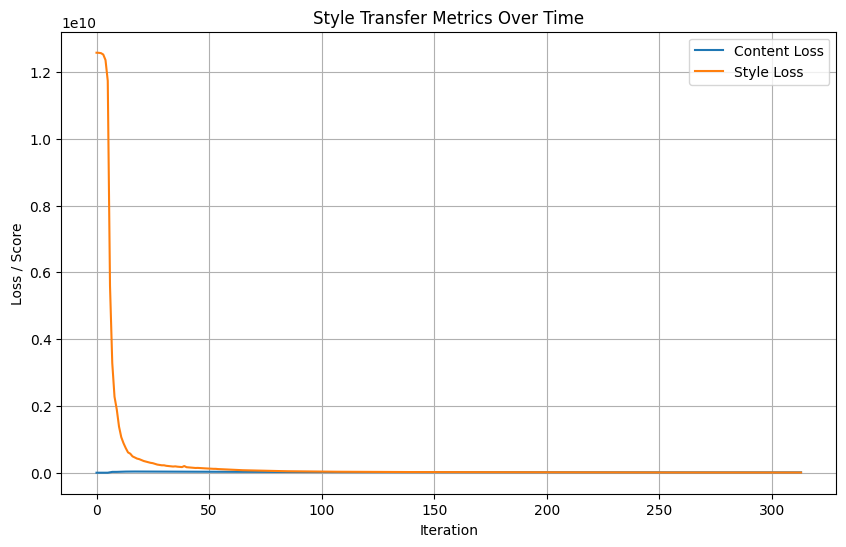


Running [50] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_100000.0_1e-05_adam_content
[10/300] Total: 1,103,982,848.00 | Content: 39,432,008.00 | Style: 1,064,264,448.00
[20/300] Total: 462,135,104.00 | Content: 39,820,616.00 | Style: 422,044,032.00
[30/300] Total: 248,658,832.00 | Content: 38,851,072.00 | Style: 209,569,568.00
[40/300] Total: 178,664,256.00 | Content: 36,742,536.00 | Style: 141,691,392.00
[50/300] Total: 138,322,224.00 | Content: 33,805,832.00 | Style: 104,284,016.00
[60/300] Total: 116,676,752.00 | Content: 31,251,704.00 | Style: 85,191,152.00
[70/300] Total: 97,374,024.00 | Content: 29,061,716.00 | Style: 68,078,776.00
[80/300] Total: 83,614,336.00 | Content: 27,083,796.00 | Style: 56,297,316.00
[90/300] Total: 110,887,056.00 | Content: 25,724,744.00 | Style: 84,927,552.00
[100/300] Total: 68,869,656.00 | Content: 24,84

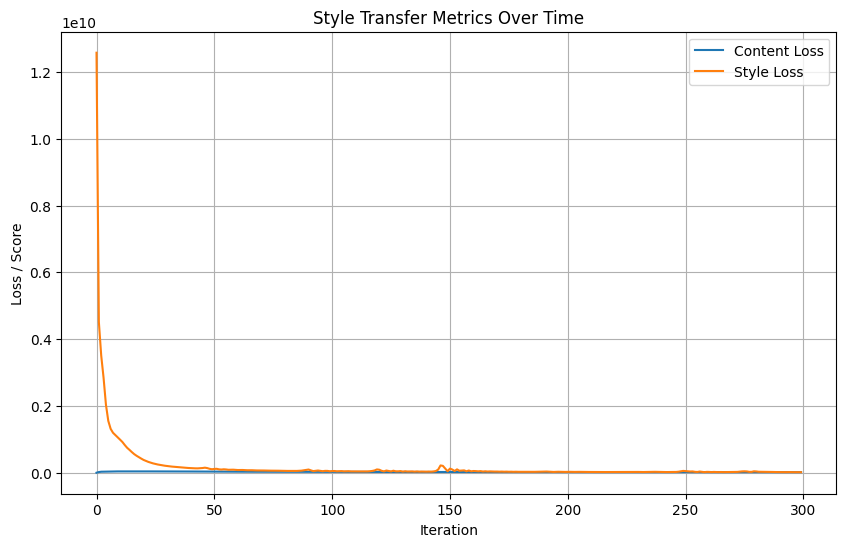


Running [51] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_100000.0_1e-05_lbfgs_content
LBFGS Step [10] Total: 1,921,612,544.00 | Content: 25,390,632.00 | Style: 1,896,070,272.00
LBFGS Step [20] Total: 442,287,744.00 | Content: 35,822,044.00 | Style: 406,302,784.00
LBFGS Step [30] Total: 257,706,400.00 | Content: 34,008,520.00 | Style: 223,548,512.00
LBFGS Step [40] Total: 187,289,056.00 | Content: 31,235,254.00 | Style: 155,909,040.00
LBFGS Step [50] Total: 140,088,432.00 | Content: 28,486,000.00 | Style: 111,460,696.00
LBFGS Step [60] Total: 107,009,600.00 | Content: 26,678,554.00 | Style: 80,191,984.00
LBFGS Step [70] Total: 85,140,200.00 | Content: 25,418,350.00 | Style: 59,585,016.00
LBFGS Step [80] Total: 71,381,648.00 | Content: 23,806,634.00 | Style: 47,441,100.00
LBFGS Step [90] Total: 61,678,044.00 | Content: 22,046,456.00 | Style

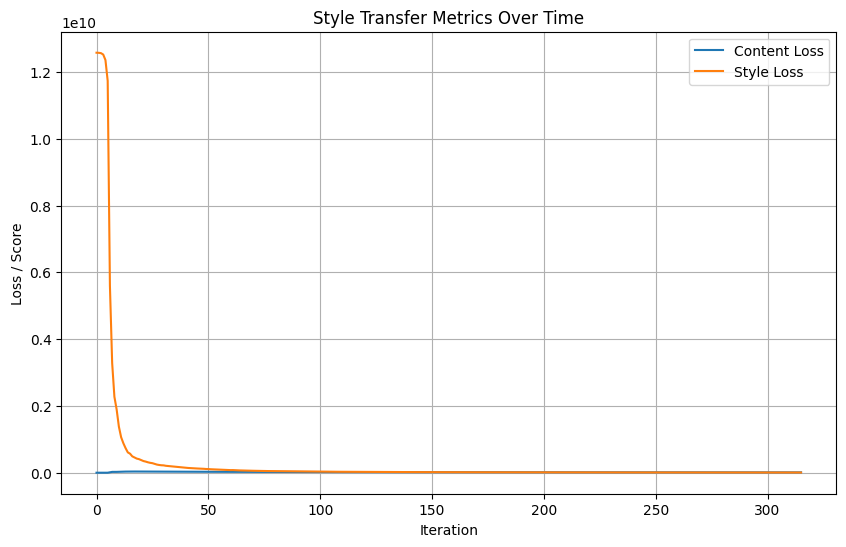


Running [52] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_100000.0_0.0001_adam_content
[10/300] Total: 1,106,126,592.00 | Content: 39,433,164.00 | Style: 1,063,832,256.00
[20/300] Total: 464,196,160.00 | Content: 39,801,400.00 | Style: 421,698,240.00
[30/300] Total: 250,624,448.00 | Content: 38,828,848.00 | Style: 209,428,928.00
[40/300] Total: 180,580,512.00 | Content: 36,691,656.00 | Style: 141,609,568.00
[50/300] Total: 140,755,488.00 | Content: 33,772,780.00 | Style: 104,693,984.00
[60/300] Total: 116,065,560.00 | Content: 31,279,422.00 | Style: 82,492,328.00
[70/300] Total: 101,007,616.00 | Content: 29,111,374.00 | Style: 69,620,160.00
[80/300] Total: 87,199,352.00 | Content: 27,191,970.00 | Style: 57,747,372.00
[90/300] Total: 77,808,192.00 | Content: 25,617,094.00 | Style: 49,938,180.00
[100/300] Total: 97,852,312.00 | Content: 24,6

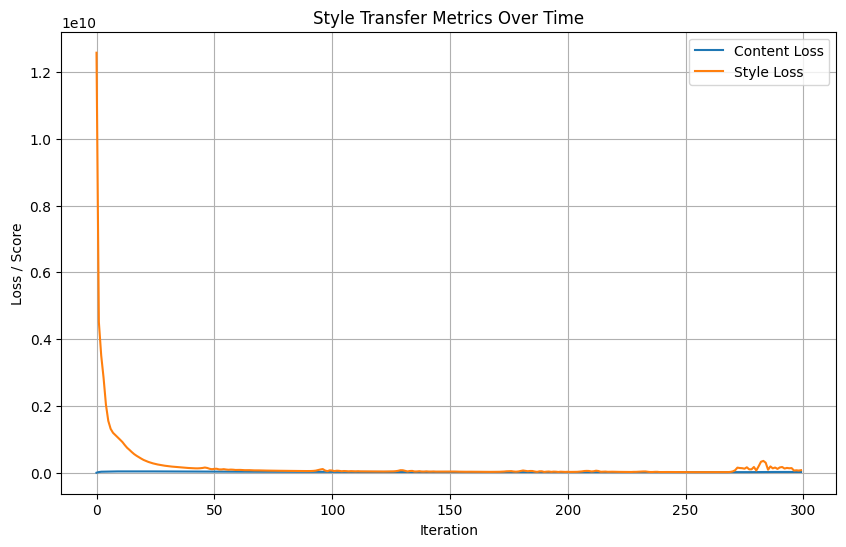


Running [53] modern-residential-building-beautiful-recreation-area-modern-residential-building-recreation-area-131403554_x_Van-Gogh-Starry-Night-Mural-Wallpaper_a08bca97-2248-4dbe-8ea5-5d413f142875_10000.0_100000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 1,922,981,248.00 | Content: 25,390,148.00 | Style: 1,896,074,624.00
LBFGS Step [20] Total: 443,022,208.00 | Content: 35,830,960.00 | Style: 405,564,896.00
LBFGS Step [30] Total: 258,355,664.00 | Content: 33,972,084.00 | Style: 222,895,488.00
LBFGS Step [40] Total: 189,900,176.00 | Content: 31,316,036.00 | Style: 157,145,744.00
LBFGS Step [50] Total: 141,152,784.00 | Content: 28,537,896.00 | Style: 111,206,984.00
LBFGS Step [60] Total: 105,290,976.00 | Content: 26,482,032.00 | Style: 77,437,416.00
LBFGS Step [70] Total: 83,834,376.00 | Content: 25,318,212.00 | Style: 57,186,388.00
LBFGS Step [80] Total: 69,294,928.00 | Content: 23,342,598.00 | Style: 44,641,928.00
LBFGS Step [90] Total: 58,067,692.00 | Content: 21,869,964.00 | Styl

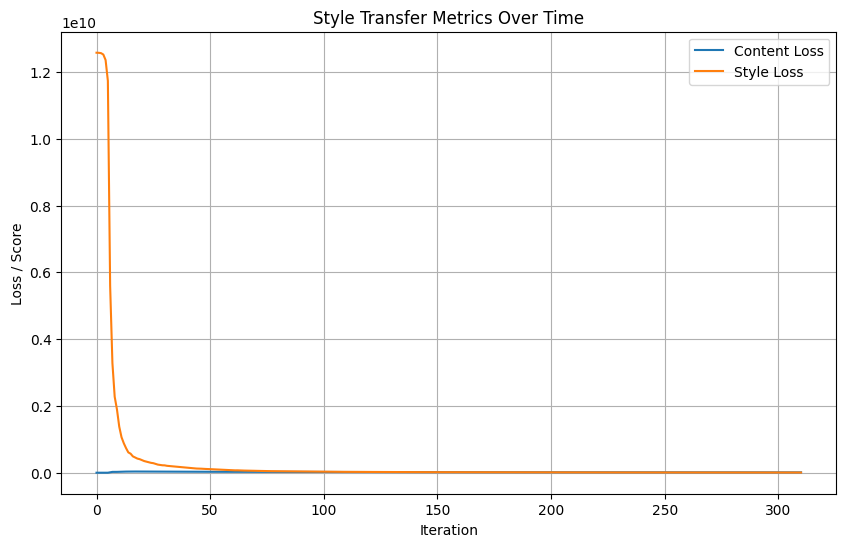

In [ ]:
# ===================================
# MAIN LOOP: APPLY TO ALL IMAGE PAIRS
# ===================================

run_index = 0

# Sort all valid image files
content_files = sorted([f for f in os.listdir(content_dir) if f.lower().endswith(('.jpg', '.png'))])
style_files = sorted([f for f in os.listdir(style_dir) if f.lower().endswith(('.jpg', '.png'))])

for content_file in content_files:
    for style_file in style_files:
        for cw, sw, tv, opt, init in product(content_weights, style_weights, tv_weights, optimizers, init_methods):

            run_id = f"{Path(content_file).stem}_x_{Path(style_file).stem}_{cw}_{sw}_{tv}_{opt}_{init}"
            output_name = f"{run_id}.jpg"

            content_path = os.path.join(content_dir, content_file)
            style_path = os.path.join(style_dir, style_file)
            output_path = os.path.join(output_dir, output_name)

            print(f"\nRunning [{run_index}] {run_id}")
            final_c, final_s, total_time = run_style_transfer(
                                          content_path, style_path, output_path,
                                          content_weight=cw,
                                          style_weight=sw,
                                          tv_weight=tv,
                                          optimizer_type=opt,
                                          init_type=init,
                                          iterations=300,
                                          learning_rate=10.0
            )

            # Log results to CSV
            with open(csv_log_path, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    run_index, run_id, content_file, style_file,
                    cw, sw, tv, opt, init, 300, 10.0,
                    final_c, final_s,
                    total_time,
                    output_path
                ])
            run_index += 1